# **Ejercicio series de tiempo**

## **Librerías y módulos necesarios**

In [2]:
import yfinance as yfin

In [ ]:
!pip install ta

In [ ]:
!pip install yahoo_fin

In [3]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from scipy.stats import shapiro
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from statsmodels.tsa import seasonal
from sklearn.metrics import r2_score
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


# **Descriptivo del conjunto de datos**

## **Datos**: **Nu Holdings Ltd. (NU)**

En este ejercicio se estará trabajando con un conjunto de datos del banco **Nu Holdings Ltd. (NU)**.

In [4]:
ticker = 'NU.CL' # Código alfanumérico (etiqueta de la base de datos)
resolution = '1d' # Muestra los datos diarios
end_date = datetime.now()
start_date = '01-06-2022'


In [5]:
data = get_data(ticker, start_date = start_date, end_date = end_date, interval = resolution, index_as_date = False)
data.drop('ticker', axis = 1, inplace = True)

## **Características de los datos**

In [6]:
data.head()

,date,open,high,low,close,adjclose,volume
0,2022-05-31,14770.0,14770.0,14590.0,14590.0,14590.0,18801.0
1,2022-06-01,14770.0,14940.0,14000.0,14000.0,14000.0,49777.0
2,2022-06-02,15400.0,16940.0,15400.0,16940.0,16940.0,62555.0
3,2022-06-03,16940.0,17170.0,16000.0,17100.0,17100.0,96867.0
4,2022-06-06,18000.0,18000.0,16260.0,16420.0,16420.0,53855.0


In [7]:
data.tail()

,date,open,high,low,close,adjclose,volume
597,2024-09-12,61220.0,61260.0,60540.0,61080.0,61080.0,3833.0
598,2024-09-13,61080.0,61300.0,60000.0,61140.0,61140.0,12773.0
599,2024-09-16,61900.0,63420.0,61900.0,63300.0,63300.0,21923.0
600,2024-09-17,63500.0,63980.0,63480.0,63680.0,63680.0,8187.0
601,2024-09-18,63680.0,63680.0,62000.0,62280.0,62280.0,9997.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      602 non-null    datetime64[ns]
 1   open      560 non-null    float64       
 2   high      560 non-null    float64       
 3   low       560 non-null    float64       
 4   close     560 non-null    float64       
 5   adjclose  560 non-null    float64       
 6   volume    560 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 33.0 KB


In [9]:
data.shape

(602, 7)

In [10]:
data.describe()

,date,open,high,low,close,adjclose,volume
count,602,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000
mean,2023-07-25 07:12:57.408637696,31560.803571,32017.232143,31168.107143,31624.160714,31624.160714,31270.600000
min,2022-05-31 00:00:00,12960.000000,13190.000000,12910.000000,12950.000000,12950.000000,659.000000
25%,2022-12-27 06:00:00,21500.000000,22000.000000,20985.000000,21617.500000,21617.500000,7160.000000
50%,2023-07-25 12:00:00,30205.000000,30865.000000,30100.000000,30350.000000,30350.000000,17291.500000
75%,2024-02-20 18:00:00,40205.000000,41020.000000,39875.000000,40525.000000,40525.000000,39283.500000
max,2024-09-18 00:00:00,64600.000000,66480.000000,63480.000000,65940.000000,65940.000000,308697.000000
std,NaN,11945.842784,12015.310478,11881.433013,11958.414183,11958.414183,37470.772272


Nótese que luego de analizar las principales características de los datos podemos deducir que cuenta con 605 observaciones y 7 columnas, de las cuales todas son de tipo numérico y la fecha está asignada como un datetime. La fecha de inicio de los datos es **01-06-2022** y la fecha final de los datos es **18-09-2024**.

## **Comportamiento de la serie**

En este caso se visualizarán los datos por medio de una serie de tiempo. Por lo tanto es importante conocer el comportamiento inicial de la serie.

Los lags son los retrasos o desfases en una serie temporal, que representan el valor de la variable en momentos previos utilizados para analizar la relación con el valor actual.

In [11]:
if data['adjclose'].isnull().sum() > 0:
    data['adjclose'] = data['adjclose'].fillna(method = 'ffill')
    # Llena los nulos con el valor anterior más cercano en la columna (método de "forward fill"), propagando los últimos valores no nulos hacia adelante.

plt.rcParams['figure.figsize'] = (8, 4)

En el siguiente gráfico, se observa la serie de tiempo correspondiente al precio de cierre ajustado de la acción de Nu Bank en el periodo de tiempo mencionado

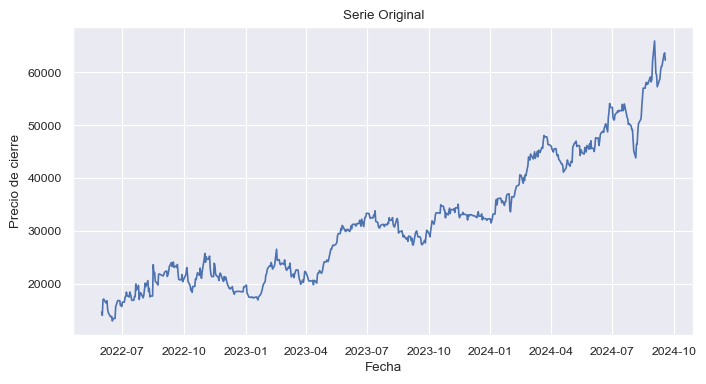

In [12]:
# Serie original
sns.set_theme()
sns.set_context("paper")
sns.lineplot(data = data, x = data.date, y = data.adjclose);
plt.title('Serie Original')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.show()

En la gráfica se observa como historicamente la accion de Nu bank va en alza en el precio. De acuerdo a la variabilidad observada, parece que esta serie **NO** es estacionaria, ya que no muestra una variabilidad tan marcada.

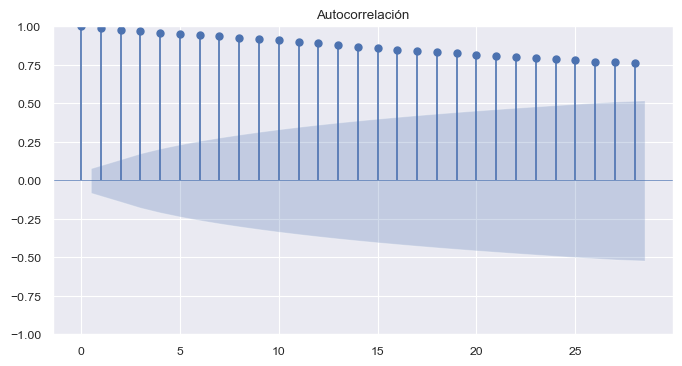

In [13]:
# Autocorrelación
# Lag: observación de una variable en un momento anterior al momento actual.
plot_acf(data['adjclose'], linewidth = 0.5)
plt.title('Autocorrelación')
plt.show()

La gráfica de autocorrelación muestra una alta correlación en los primeros lags, que disminuye gradualmente con el tiempo. La mayoría de las barras caen en la zona sombreada, indicando que esas correlaciones no son significativas. 

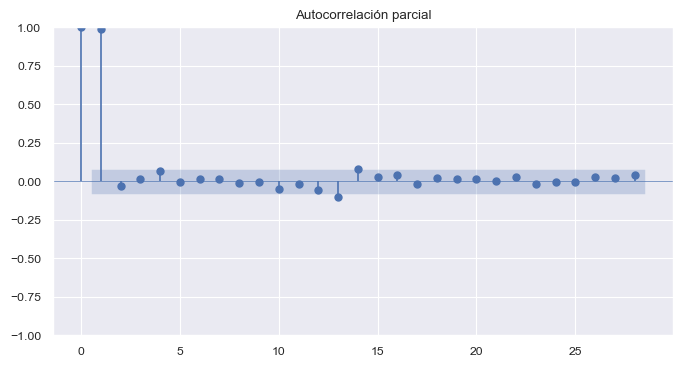

In [14]:
# Autocorrelación Parcial
plot_pacf(data['adjclose'], linewidth = 0.5)
plt.title('Autocorrelación parcial')
plt.show()

La gráfica de autocorrelación parcial revela una fuerte dependencia entre el último día y el anterior, pero esta disminuye rápidamente con lags mayores, mostrando correlaciones bajas y poco significativas en días posteriores.

### **Test de Dickey-Fuller.**

En esta parte se usará la prueba de `Dickey-Fuller` para verificar si la serie de tiempo es estacionaria o no.

- **Hipótesis Nula (H₀):** La serie de tiempo es NO estacionaria (tiene una raíz unitaria)
- **Hipótesis Alternativa (H₁):** La serie de tiempo es estacionaria (no tiene una raíz unitaria)

In [15]:
adf_result = adfuller(data["adjclose"].tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: 0.708935
p-value: 0.990015


Dado que el p-valor (`0.99`) es mayor que el nivel de significancia (`0.05`) entonces NO rechazamos la hipótesis nula y por tanto se afirma está misma. Es decir, la serie de tiempo NO es estacionaria.

### **Descomposición de la serie**

La descomposición de una serie temporal permite separar sus componentes principales: tendencia, estacionalidad y ruido. Esto facilita la identificación de patrones ocultos, mejora los modelos predictivos y ayuda a analizar mejor los efectos de largo plazo y las fluctuaciones estacionales, aislando el ruido aleatorio.

En esta parte, intentaremos descomponer la serie temporal y, en consecuencia, estacionarla utilizando la función `_seasonal.seasonal decompose` . Probemos primero con el modelo aditivo de la descomposición.

El **método aditivo** de descomposición es importante porque asume que los componentes de la serie temporal (tendencia, estacionalidad y ruido) se combinan de forma aditiva, es decir, la serie observada es la suma de estos tres elementos: $( Y(t) = T(t) + S(t) + R(t) )$. Este método es especialmente útil cuando las variaciones estacionales y el ruido permanecen constantes a lo largo del tiempo, independientemente del nivel de la tendencia.

In [28]:
decompose_model = seasonal.seasonal_decompose(data["adjclose"].tolist(),period = 20, model = 'additive')
# El comportamiento de la serie tiene un ciclo estacional que se repite cada 20 días.

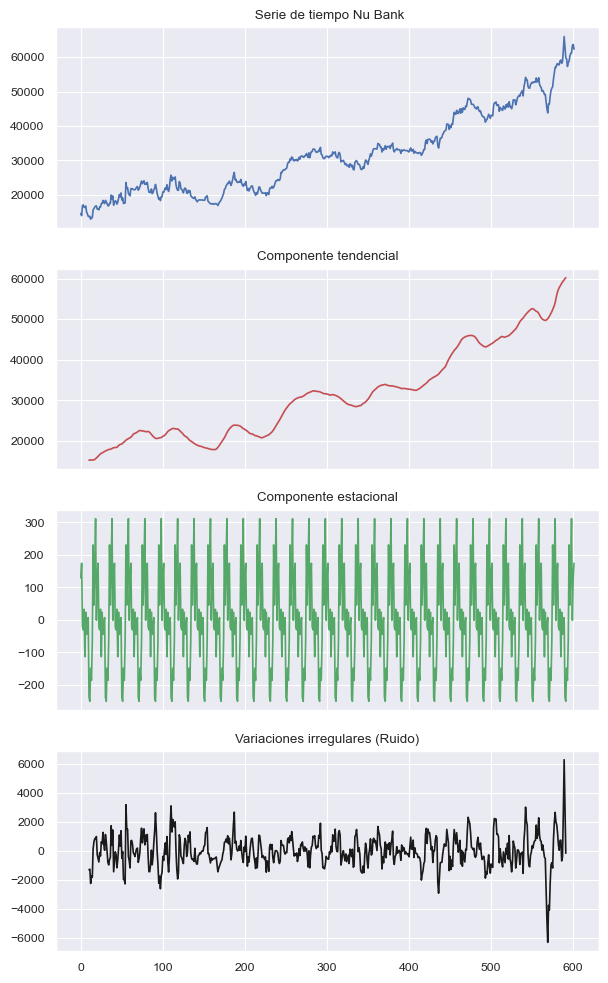

In [30]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(7, 12)
sns.set_theme()
sns.set_context("paper")

data['adjclose'].plot(ax = axarr[0], color = 'b', linestyle = '-')
axarr[0].set_title(' Serie de tiempo Nu Bank')

pd.Series(data = decompose_model.trend, index = data.index).plot(color = 'r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Componente tendencial')

pd.Series(data = decompose_model.seasonal, index = data.index).plot(color = 'g', linestyle = '-', ax=axarr[2])
axarr[2].set_title('Componente estacional')

pd.Series(data = decompose_model.resid, index = data.index).plot(color = 'k', linestyle = '-', ax=axarr[3])
axarr[3].set_title('Variaciones irregulares (Ruido)');


En el primer gráfico, el **componente tendencial** muestra un aumento a lo largo del tiempo. El segundo gráfico representa la **estacionalidad**, que exhibe un patrón repetitivo con una amplitud constante, lo que indica un comportamiento cíclico regular. Finalmente, el último gráfico muestra el **ruido**, compuesto por variaciones aleatorias sin un patrón definido, lo que sugiere que estos movimientos no pueden ser explicados ni por la tendencia ni por la estacionalidad.

Ahora ejecutamos la prueba ADF sobre los residuos del modelo aditivo.

In [31]:
adf_result = adfuller(decompose_model.resid[np.where(np.isfinite(decompose_model.resid))[0]], autolag = 'AIC')
print('p-valor:', adf_result[1])

p-valor: 8.445648812462605e-12


Aplicando la prueba a los residuos del modelo aditivo obtenemos un p-valor de **8.445648812462605e-12**, que es mucho menor que el obtenido con la serie temporal original.

### **Prueba de normalidad.**
Ahora, veamos la normalidad del conjunto de datos residuales.

- **Hipótesis Nula (H₀):** La muestra parece provenir de una distribución normal.
- **Hipótesis Alternativa (H₁):** La muestra NO parece provenir de una distribución normal.

In [32]:
decompose_model = seasonal.seasonal_decompose(data["adjclose"].tolist(),period = 20, model = 'additive')
resid_clean = decompose_model.resid
resid_clean = np.where(np.isinf(resid_clean), np.nan, resid_clean)  # Reemplazar infinitos por NaN
resid_clean = resid_clean[~np.isnan(resid_clean)]  # Eliminar los NaN

# Reemplaza los valores infinitos por NA y luego elimina los NA
stat , p = shapiro(resid_clean)
print('Statistics = %.3f, p = %.3f' % (stat, p))

Statistics = 0.955, p = 0.000


Dado que el p-valor es un valor pequeño, menor que el valor de significancia (`0.05`) se rechaza la hipótesis nula y se afirma la alternativa, es decir la muestra de los residuos NO parece provenir de una distribución normal.

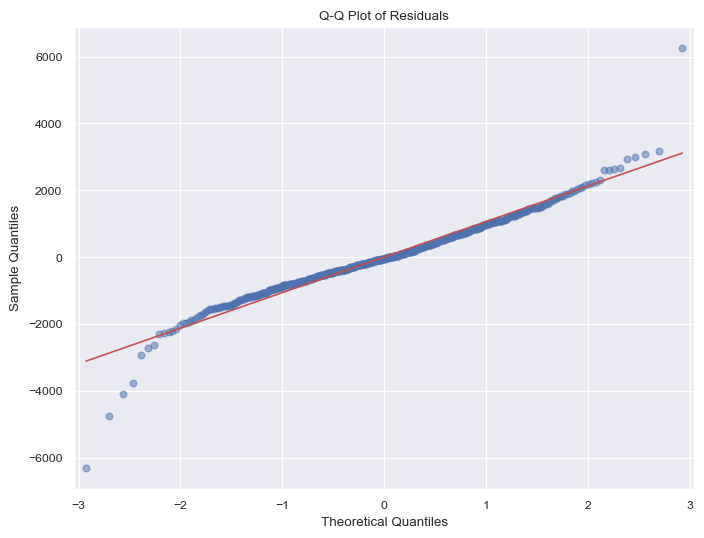

In [33]:
decompose_model = seasonal.seasonal_decompose(data['adjclose'], period=20, model='additive')
plt.rcParams.update({'figure.figsize': (8, 6)})
fig = sm.qqplot(decompose_model.resid.dropna(), line='s', alpha=0.5, color='b', lw=2)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

La gráfica muestra un indicio de normalidad significativa en el conjunto de datos residuales de NU bank. Sin embargo, notamos que algunos residuos presentan una tendencia NO normal respecto al resto de datos de la muestra, lo cual confirma lo anteriormente dicho en la prueba de normalidad.

# **Modelo ARIMA**

El objetivo del análisis de series temporales es construir un modelo matemático capaz de capturar y explicar los patrones observados en una serie temporal, permitiendo no solo comprender su comportamiento histórico, sino también predecir con precisión su evolución futura.

## **Diferenciación**

Dado que ya observamos que la serie de tiempo correspondiente a los datos de Nu Bank no son estacionarios, entonces, usaremos la diferenciación para estacionarlos y posteriormente usar el Modelo `ARIMA` (Autorregresivo integrado de media móvil).

La diferenciación busca convertir una serie temporal no estacionaria en estacionaria, eliminando tendencias y preparando los datos para análisis y predicciones más precisas mediante modelos adecuados.

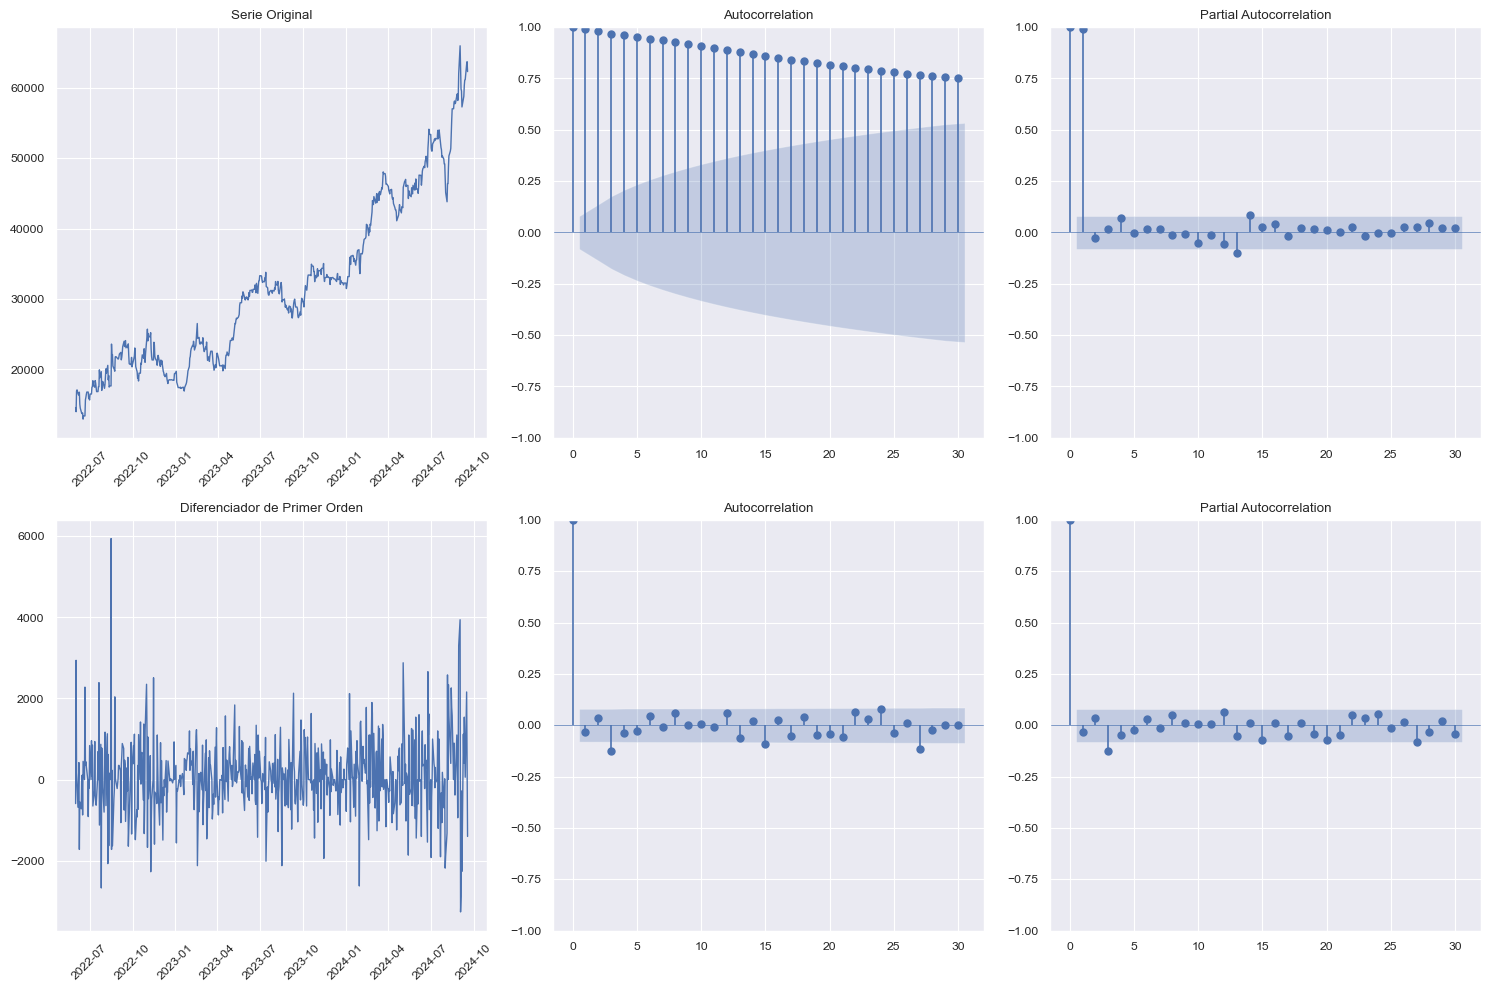

In [34]:
plt.rcParams.update({'text.usetex'     : False})
plt.rcParams.update({'figure.figsize'  : (15, 10)})

nlag = 30
fig, axes = plt.subplots(2, 3, sharex = False)

# Serie Original
axes[0, 0].plot(data['date'], data['adjclose'], linewidth = 1)
axes[0, 0].set_title('Serie Original')
plot_acf(data["adjclose"], lags = nlag, linewidth = 0.5, ax = axes[0, 1])
plot_pacf(data["adjclose"], lags = nlag, linewidth = 0.5, ax = axes[0, 2])

# Diferenciador de Primer Orden
axes[1, 0].plot(data["date"], data['adjclose'].diff(), linewidth = 1)
axes[1, 0].set_title('Diferenciador de Primer Orden')
plot_acf(data["adjclose"].diff().dropna(), lags = nlag, linewidth = 0.5, ax = axes[1, 1])
plot_pacf(data["adjclose"].diff().dropna(), lags = nlag, linewidth = 0.5, ax = axes[1, 2])

# Rotar los valores del eje x solo para las gráficas de las series temporales
for ax in [axes[0, 0], axes[1, 0]]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

plt.tight_layout()
plt.show()


Después de aplicar el diferenciador de primer orden, la serie se vuelve más estacionaria, eliminando la tendencia a largo plazo. Esto se confirma en los gráficos ACF y PACF de la serie diferenciada, donde las correlaciones son más débiles, lo que indica que el proceso de diferenciación ha sido efectivo para eliminar la tendencia original y facilitar un análisis más claro de los cambios en los valores recientes.

Comprobemos la estacionalidad de la primera diferenciación con la prueba de `Dickey-Fuller`

In [36]:
adjclose_diff = data["adjclose"].diff().dropna()
adf_result2 = adfuller(adjclose_diff)
print('ADF Statistic: %f' % adf_result2[0])
print('p-value: %f' % adf_result2[1])

ADF Statistic: -15.830362
p-value: 0.000000


Dado el p-valor bajo que presenta la prueba luego de haber realizado la diferenciación de primer orden a los datos es posible afirmar que la serie es **Estacionaria** y ahora está lista para aplicar el modelo ARIMA

## **Criterios AIC, BIC y HQIC**
Los criterios de información de Akaike (AIC), Bayesiano (BIC) y de Hannan-Quinn (HQIC) utilizan el método de estimación de máxima verosimilitud (log-verosimilitud) de los modelos como medida de ajuste. Estas medidas buscan valores bajos para indicar un mejor ajuste del modelo a los datos.

Se realiza la división de los datos para el entrenamiento y test del modelo.

In [37]:
n_data = len(data.adjclose)
n_test = 30
train_size = n_data - n_test

In [38]:
train = data.adjclose[:train_size]
dates_train = data.date[:train_size]

test = data.adjclose[train_size:train_size + n_test]
dates_test = data.date[train_size:train_size + n_test]

print("Train:", train.shape)
print("Test:", test.shape)

Train: (572,)
Test: (30,)


In [39]:
# tolist se usa para convertir a listas estándar de python
train_list = train.tolist()

test7 = data.adjclose[train_size:train_size + 7]
dates_test7 = data.date[train_size:train_size + 7]
test7 = test7.tolist()


test14 = data.adjclose[train_size:train_size + 14]
dates_test14 = data.date[train_size:train_size + 14]
test14 = test14.tolist()


test21 = data.adjclose[train_size:train_size + 21]
dates_test21 = data.date[train_size:train_size + 21]
test21 = test21.tolist()


test28 = data.adjclose[train_size:train_size + 28]
dates_test28 = data.date[train_size:train_size + 28]
test28 = test28.tolist()

Ahora, se ajustará el modelo ARIMA para explorar diferentes combinaciones de órdenes `p,d,q`. Se utilizará el método de máxima verosimilitud `method = 'mle'` para el cálculo de la verosimilitud exacta a través del filtro de Kalman.

- `p`: Corresponde al orden de la parte autoregresiva del modelo (AR). Representan el número de observaciones pasadas (lags) que se utilizan para predecir el valor actual de la serie.
- `d`: Corresponde al número de diferenciaciones que se le realizan a la serie de tiempo para hacerla estacionaria.
- `q`: Corresponde al orden de la parte de media móvil del modelo (MA) y representa cuántos errores pasados están influyendo en el valor presente de la serie.

In [40]:
train_df = data[["adjclose"]][:train_size]
test_df = data[["adjclose"]][train_size:train_size + n_test]

En esta parte se encuentra el mejor modelo y las mejores combinaciones de órdenes para cada uno de los tres tipos de criterios (AIC, BIC y HQIC) evaluando en el conjunto de entrenamiento.

In [41]:
def best_model(train):
    # Inicializar los mejores valores
    best_aic = np.inf  # Mejor AIC
    best_bic = np.inf  # Mejor BIC
    best_hqic = np.inf  # Mejor HQIC

    best_order_aic = None  # Mejor orden para AIC
    best_order_bic = None  # Mejor orden para BIC
    best_order_hqic = None  # Mejor orden para HQIC

    best_mdl_aic = None  # Mejor modelo basado en AIC
    best_mdl_bic = None  # Mejor modelo basado en BIC
    best_mdl_hqic = None  # Mejor modelo basado en HQIC

    # Rango de p, d y q
    pq_rng = range(5)
    d_rng = range(3)

    # Iterar sobre todos los posibles valores de p, d, q
    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                try:
                    # Ajustar el modelo ARIMA
                    tmp_mdl = ARIMA(train, order=(p, d, q)).fit()

                    # Obtener los valores de AIC, BIC y HQIC
                    tmp_aic = tmp_mdl.aic
                    tmp_bic = tmp_mdl.bic
                    tmp_hqic = tmp_mdl.hqic

                    # Comparar el AIC
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order_aic = (p, d, q)
                        best_mdl_aic = tmp_mdl

                    # Comparar el BIC
                    if tmp_bic < best_bic:
                        best_bic = tmp_bic
                        best_order_bic = (p, d, q)
                        best_mdl_bic = tmp_mdl

                    # Comparar el HQIC
                    if tmp_hqic < best_hqic:
                        best_hqic = tmp_hqic
                        best_order_hqic = (p, d, q)
                        best_mdl_hqic = tmp_mdl

                except:
                    continue

    return {
        'AIC': {'best_aic': best_aic, 'best_order': best_order_aic, 'best_model': best_mdl_aic},
        'BIC': {'best_bic': best_bic, 'best_order': best_order_bic, 'best_model': best_mdl_bic},
        'HQIC': {'best_hqic': best_hqic, 'best_order': best_order_hqic, 'best_model': best_mdl_hqic}
    }

# Usar la función con tus datos de entrenamiento
results = best_model(train)

print("Mejor modelo basado en AIC:", results['AIC'])
print("Mejor modelo basado en BIC:", results['BIC'])
print("Mejor modelo basado en HQIC:", results['HQIC'])

Mejor modelo basado en AIC: {'best_aic': 9328.140365675212, 'best_order': (0, 1, 3), 'best_model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000022EF130CE20>}
Mejor modelo basado en BIC: {'best_bic': 9344.644888011499, 'best_order': (1, 1, 1), 'best_model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000022EF161D8E0>}
Mejor modelo basado en HQIC: {'best_hqic': 9334.924714317407, 'best_order': (0, 1, 3), 'best_model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000022EF130CE20>}


## **Modelo ARIMA con rolling forecast**

Ahora realizaremos pronósticos utilizando el método de **pronóstico continuo** o **rolling forecasting**, el cual aprovecha los datos históricos para generar predicciones continuas sobre un período. Este enfoque permite hacer ajustes en tiempo real, optimizar la planificación y mejorar la toma de decisiones. En nuestro caso, aplicaremos este método para prever horizontes de 7, 14, 21 y 28 días, para cada uno de los criterios.

In [42]:
def arima_rolling(history, test, best_order):

    predictions = []  # Lista donde se almacenarán las predicciones

    # Recorrer el conjunto de prueba
    for t in range(len(test)):
        # Crear y ajustar un modelo ARIMA con los datos históricos
        model = ARIMA(history, order = best_order)
        model_fit = model.fit()

        # Generar pronóstico para el siguiente valor (1 paso adelante)
        output = model_fit.forecast()
        yhat = output[0]  # El pronóstico es el primer valor del forecast

        predictions.append(yhat)  # Almacenar la predicción en la lista

        # Obtener el valor real observado en el conjunto de prueba
        obs = test[t]

        # Añadir la observación actual al conjunto de datos históricos
        history.append(obs)

        # Imprimir el valor pronosticado y el valor real
        print('predicho = %f, esperado = %f' % (yhat, obs))

    return predictions

Ahora se segmenta el conjunto de datos en intervalos de prueba con horizontes de 7, 14, 21 y 28 días, donde se extraen los valores ajustados de cierre y las fechas correspondientes para cada horizonte

## **Modelo ARIMA sin rolling forecast**

Para realizar el pronóstico sin el enfoque **rolling**, simplemente debemos eliminar la línea de código que actualiza el conjunto `history` con los valores observados del `test`. Esto implica que, en la nueva función, el conjunto de entrenamiento permanecerá estático y no se ajustará con cada nueva predicción.

In [43]:
def arima_sin_rolling(test, modelo):
    # Calcular el número de pasos de predicción basados en el tamaño del conjunto de prueba
    forecast_steps = len(test)
    
    # Realizar las predicciones para el número de pasos determinado
    forecast_tipo = modelo.forecast(steps=forecast_steps)
    
    # Convertir a un array para acceder por índice numérico
    forecast_values = forecast_tipo.values
    
    # Imprimir los valores observados y predichos
    for i in range(len(test)):
        observado = test[i]  # Valores observados
        predicho = forecast_values[i]  # Acceder a los valores predichos por índice
        print(f'Predicho: {predicho}, Observado: {observado}')

    # Devolver las predicciones
    return forecast_values

A continuación se ajustará el modelo para cada criterio y sus diferentes características para el modelo ARIMA

## **Tabla de error**

En esta parte se crea un método que permite calcular las tablas de error utilizando las métricas `MAPE, MAE, RMSE, MSE`

In [44]:
def forecast_accuracy(forecast, actual, str_name):

    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)

    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])

    return df_acc

## **Criterio AIC**

### **Modelo ajustado**

Inicialmente, se ajustará el modelo teniendo en cuenta los mejores ordenes obtenidos anteriormente para el criterio de **Akaike**.

In [45]:
best_order_aic = results['AIC']['best_order']
model_aic = ARIMA(train, order = best_order_aic)
model_fit_aic = model_aic.fit()

La siguiente gráfica representa la predicción realizada utilizando el modelo ARIMA ajustado al conjunto de datos de entrenamiento y al mejor orden obtenido para el criterio AIC

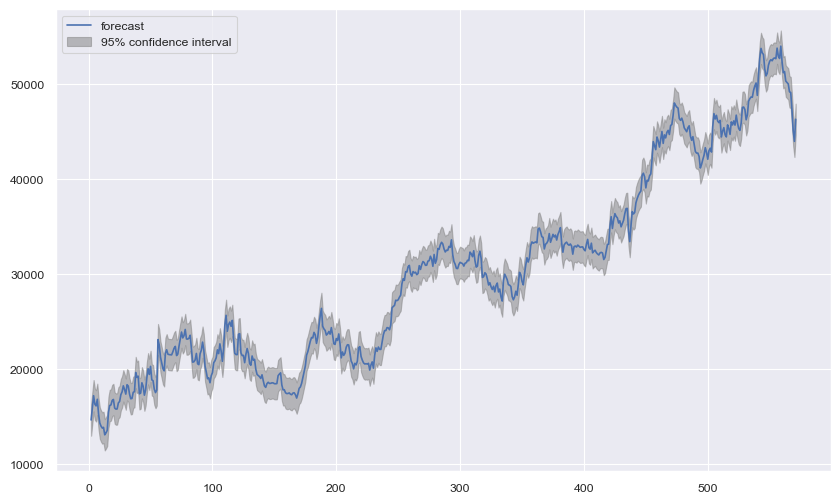

In [46]:
plt.rcParams.update({'figure.figsize': (10,6)})
plot_predict(model_fit_aic, 2);
# El valor 2 significa que la predicción comenzará desde la segunda observación.
plt.show();

### **Modelo ARIMA con rolling forecast**

Ahora, apliquemos el modelo ARIMA con rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio AIC

In [47]:
print('ARIMA Rolling AIC- Horizonte de 7 días.')
yhat7_aic = arima_rolling(train_list, test7, best_order_aic)

print('\nARIMA Rolling AIC - Horizonte de 14 días.')
yhat14_aic = arima_rolling(train_list, test14, best_order_aic)

print('\nARIMA Rolling AIC - Horizonte de 21 días.')
yhat21_aic = arima_rolling(train_list, test21, best_order_aic)

print('\nARIMA Rolling AIC - Horizonte de 28 días.')
yhat28_aic = arima_rolling(train_list, test28, best_order_aic)

ARIMA Rolling AIC- Horizonte de 7 días.
predicho = 46779.309378, esperado = 48720.000000
predicho = 48214.100052, esperado = 50300.000000
predicho = 50325.009903, esperado = 50980.000000
predicho = 50911.273893, esperado = 51380.000000
predicho = 51162.502990, esperado = 53640.000000
predicho = 53437.923697, esperado = 55420.000000
predicho = 55537.981501, esperado = 57000.000000

ARIMA Rolling AIC - Horizonte de 14 días.
predicho = 56910.626085, esperado = 48720.000000
predicho = 49257.525877, esperado = 50300.000000
predicho = 49205.820989, esperado = 50980.000000
predicho = 51989.374440, esperado = 51380.000000
predicho = 51408.738370, esperado = 53640.000000
predicho = 53156.827250, esperado = 55420.000000
predicho = 55424.947995, esperado = 57000.000000
predicho = 56764.036695, esperado = 57000.000000
predicho = 56833.779490, esperado = 57900.000000
predicho = 57651.334054, esperado = 58100.000000
predicho = 58123.357283, esperado = 57720.000000
predicho = 57669.639858, esperado =

Graficamos lo anterior

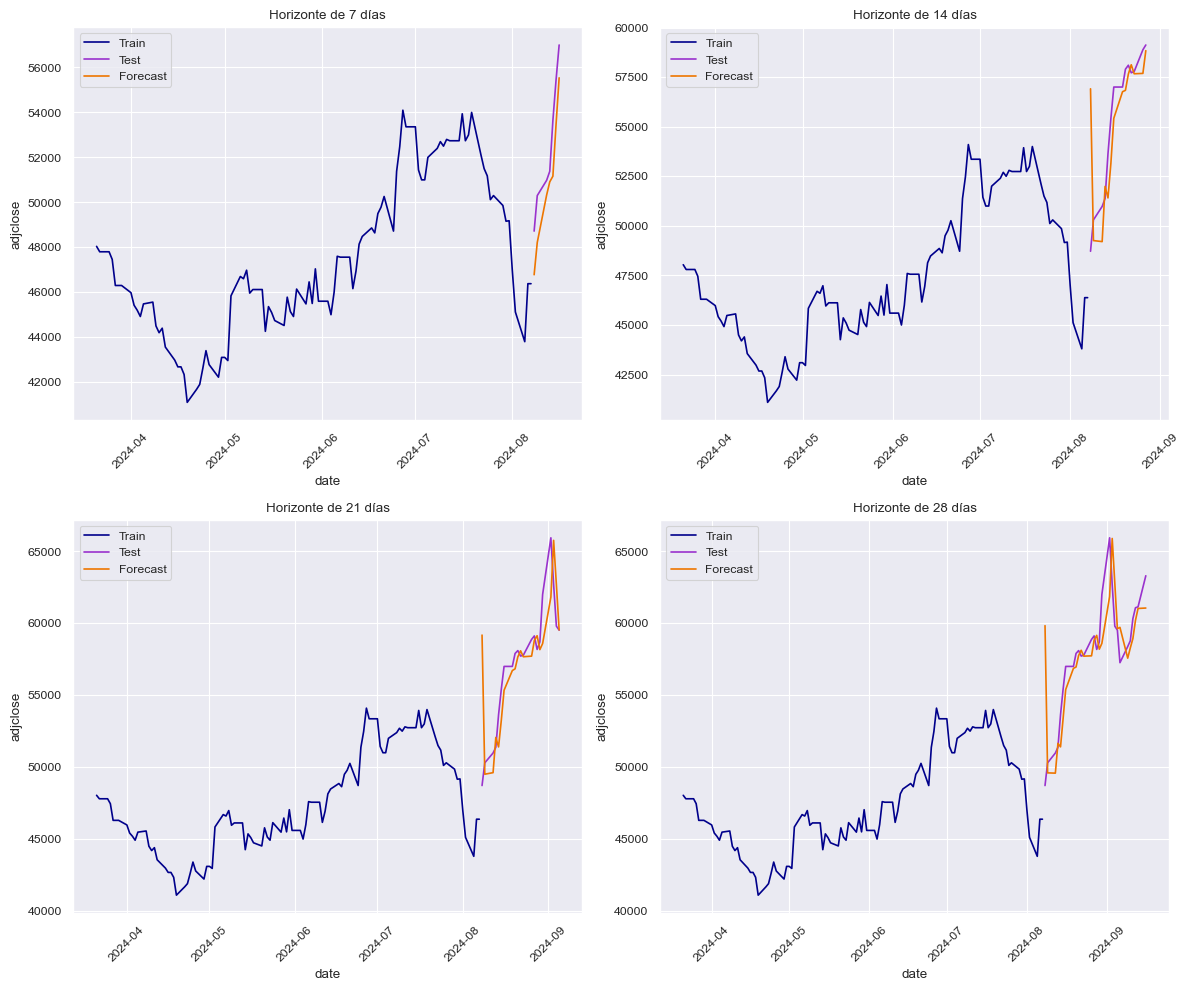

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# -100: seleccionar los últimos 100 elementos.

# Horizonte de 7 días
sns.lineplot(ax = axs[0, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = test7, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = yhat7_aic, label = 'Forecast', color = '#EE7600')
axs[0, 0].set_title('Horizonte de 7 días')
axs[0, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = test14, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = yhat14_aic, label = 'Forecast', color = '#EE7600')
axs[0, 1].set_title('Horizonte de 14 días')
axs[0, 1].tick_params(axis = 'x', rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = test21, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = yhat21_aic, label = 'Forecast', color = '#EE7600')
axs[1, 0].set_title('Horizonte de 21 días')
axs[1, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = test28, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = yhat28_aic, label = 'Forecast', color = '#EE7600')
axs[1, 1].set_title('Horizonte de 28 días')
axs[1, 1].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()


En las gráficas se observan las predicciones del modelo ARIMA para diferentes horizontes de tiempo: 7, 14, 21 y 28 días. En todas ellas, la línea azul representa los datos de entrenamiento, la línea morada los datos de prueba, y la línea naranja muestra las predicciones del modelo. 

### **Modelo ARIMA sin rolling forecast**

Veamos ahora el modelo ARIMA sin rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio AIC


In [49]:
print('ARIMA sin Rolling AIC - Horizonte de 7 días.')
yhat7_sin_aic = arima_sin_rolling(test7, model_fit_aic)

print('\nARIMA sin Rolling AIC - Horizonte de 14 días.')
yhat14_sin_aic = arima_sin_rolling(test14, model_fit_aic)

print('\nARIMA sin Rolling AIC - Horizonte de 21 días.')
yhat21_sin_aic = arima_sin_rolling(test21, model_fit_aic)

print('\nARIMA sin Rolling AIC - Horizonte de 28 días')
yhat28_sin_aic = arima_sin_rolling(test28, model_fit_aic)

ARIMA sin Rolling AIC - Horizonte de 7 días.
Predicho: 46779.309377534344, Observado: 48720.0
Predicho: 46470.4733200552, Observado: 50300.0
Predicho: 46462.53623532002, Observado: 50980.0
Predicho: 46462.53623532002, Observado: 51380.0
Predicho: 46462.53623532002, Observado: 53640.0
Predicho: 46462.53623532002, Observado: 55420.0
Predicho: 46462.53623532002, Observado: 57000.0

ARIMA sin Rolling AIC - Horizonte de 14 días.
Predicho: 46779.309377534344, Observado: 48720.0
Predicho: 46470.4733200552, Observado: 50300.0
Predicho: 46462.53623532002, Observado: 50980.0
Predicho: 46462.53623532002, Observado: 51380.0
Predicho: 46462.53623532002, Observado: 53640.0
Predicho: 46462.53623532002, Observado: 55420.0
Predicho: 46462.53623532002, Observado: 57000.0
Predicho: 46462.53623532002, Observado: 57000.0
Predicho: 46462.53623532002, Observado: 57900.0
Predicho: 46462.53623532002, Observado: 58100.0
Predicho: 46462.53623532002, Observado: 57720.0
Predicho: 46462.53623532002, Observado: 5778

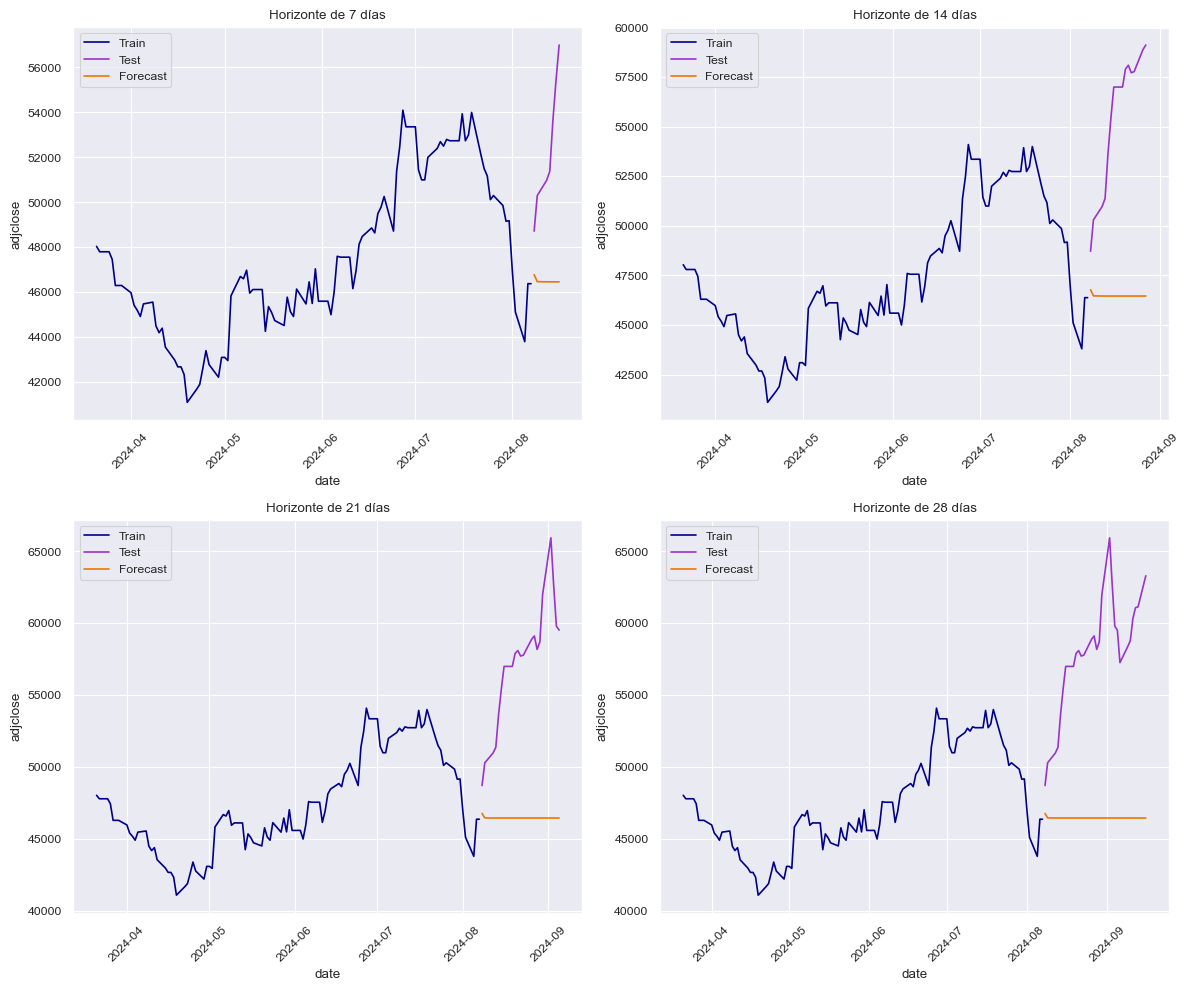

In [50]:
fig , axs = plt.subplots(2 , 2 , figsize = (12 , 10))

# Horizonte de 7 días
sns.lineplot(ax = axs[0 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = test7 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = yhat7_sin_aic , label = "Forecast" , color = '#EE7600')
axs[0 , 0].set_title("Horizonte de 7 días")
axs[0 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = test14 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = yhat14_sin_aic , label = "Forecast" , color = '#EE7600')
axs[0 , 1].set_title("Horizonte de 14 días")
axs[0 , 1].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = test21 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = yhat21_sin_aic , label = "Forecast" , color = '#EE7600')
axs[1 , 0].set_title("Horizonte de 21 días")
axs[1 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = test28 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = yhat28_sin_aic , label = "Forecast" , color = '#EE7600')
axs[1 , 1].set_title("Horizonte de 28 días")
axs[1 , 1].tick_params(axis = 'x' , rotation = 45)

plt.tight_layout()
plt.show()

### **Análisis de residuos modelo ARIMA basado en el criterio AIC**

#### **Normalidad de los residuos**

Ahora, veamos la normalidad del conjunto de datos residuales por medio de la prueba de `Shapiro-Wilk` y luego veamos gráficamente la distribución.

- **Hipótesis Nula (H₀):** La muestra parece provenir de una distribución normal.
- **Hipótesis Alternativa (H₁):** La muestra NO parece provenir de una distribución normal.

Statistic = 0.753
P-Value = 2.2116616134743827e-28
Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.


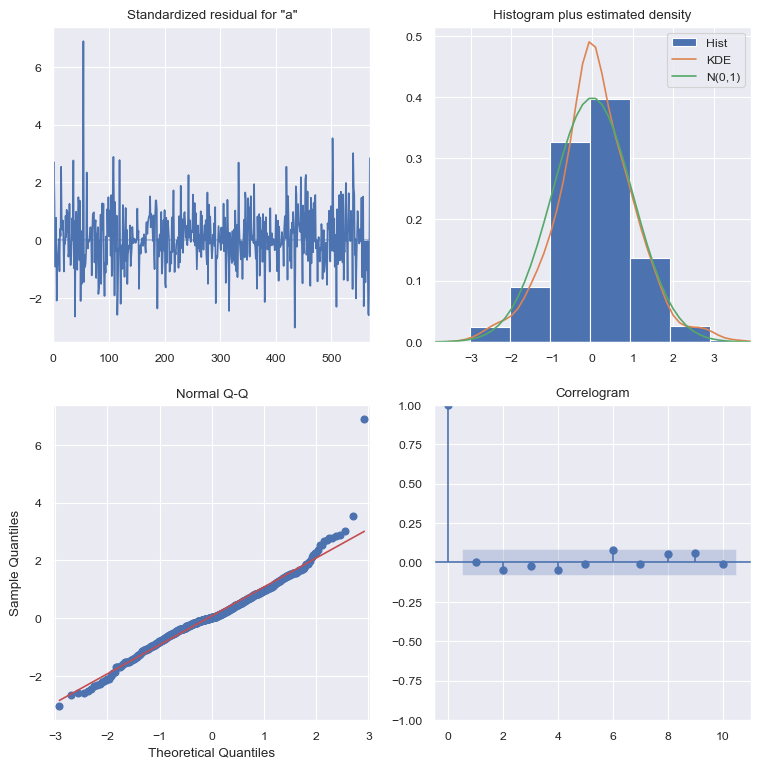

In [51]:
qq = model_fit_aic.plot_diagnostics(figsize=(9,9))

stat, pvalue = shapiro(model_fit_aic.resid)
print(f'Statistic = {stat:.3f}')
print(f'P-Value = {pvalue}')
if(pvalue < 0.05):
    print('Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.')
else:
    print('No se rechaza la hipótesis nula, por lo tanto los residuales siguen una distribución normal.')

#### **Independencia de los residuos**

Uno de los principales supuestos de los modelos es que NO existe autocorrelación entre los residuos. Se usará la prueba de `Durbin-Watson`, teniendo en cuenta las siguientes hipótesis.


- **Hipótesis Nula (H₀):** No existe correlación entre los residuos
- **Hipótesis Alternativa (H₁):** Los residuos están correlacionados

Usaremos el estadístico de prueba para determinar si hay o no autocorrelación entre los residuos, dado que la prueba en sí no da un p-valor en su cálculo

Si:
- d = 2, NO hay autocorrelación
- d < 2, correlación positiva
- d > 2, correlación negativa.

In [46]:
dw = durbin_watson(model_fit_aic.resid)

print(f'Statistic d = {dw:.3f}')
if(dw < 1.5 or dw > 2.5):
    print('Se rechaza la hipótesis nula, los residuales están correlacionados.')
else:
    print('No se rechaza la hipótesis nula, no existe correlación entre los residuales.')

Statistic d = 1.639
No se rechaza la hipótesis nula, no existe correlación entre los residuales.


Luego de haber analizado los supuestos en los residuos de este modelo teniendo en cuenta el criterio AIC , se puede afirmar que los residuos no siguen una distribución normal y son dependientes entre sí, es decir, están correlacionados.

### **Comparación de modelos - Criterio AIC**

#### **Tablas de error**

Veamos las tablas de error tanto para el modelo ARIMA con y sin rolling forecast teniendo en cuenta el criterio AIC

In [52]:
accuracy7_aic =  forecast_accuracy(np.array(test7), np.array(yhat7_aic), "7 días")
accuracy14_aic = forecast_accuracy(np.array(test14), np.array(yhat14_aic), "14 días")
accuracy21_aic = forecast_accuracy(np.array(test21), np.array(yhat21_aic), "21 días")
accuracy28_aic = forecast_accuracy(np.array(test28), np.array(yhat28_aic), "28 días")

accuracy_rolling = pd.concat([accuracy7_aic, accuracy14_aic, accuracy21_aic, accuracy28_aic])

In [53]:
accuracy7_not_aic = forecast_accuracy(np.array(test7), np.array(yhat7_sin_aic), "7 días")
accuracy14_not_aic = forecast_accuracy(np.array(test14), np.array(yhat14_sin_aic), "14 días")
accuracy21_not_aic = forecast_accuracy(np.array(test21), np.array(yhat21_sin_aic), "21 días")
accuracy28_not_aic = forecast_accuracy(np.array(test28), np.array(yhat28_sin_aic), "28 días")

accuracy_not_rolling = pd.concat([ accuracy7_not_aic, accuracy14_not_aic, accuracy21_not_aic, accuracy28_not_aic])

In [54]:
accuracy_rolling

,MAE,MSE,MAPE,RMSE,R2
7 días,1581.699798,2.995727e+06,0.031259,1730.816937,0.602604
14 días,1530.574416,6.238887e+06,0.028023,2497.776387,0.470274
21 días,1813.455102,8.351676e+06,0.031216,2889.926567,0.514465
28 días,1655.216276,7.276012e+06,0.028196,2697.408441,0.525303


De la tabla de error calculada al modelo ARIMA usando el rolling forecast y teniendo en cuenta el criterio AIC se puede decir que el valor de $R^2$ es positivo, lo que indica que el modelo es más capaz de explicar la varianza de los datos en predicciones de 7. 14. 21. 28 dias

In [55]:
accuracy_not_rolling

,MAE,MSE,MAPE,RMSE,R2
7 días,5982.505161,4.368725e+07,0.128717,6609.633329,-4.795308
14 días,8795.698748,8.945109e+07,0.189286,9457.858878,-6.595039
21 días,10701.048992,1.319784e+08,0.230302,11488.183589,-6.672728
28 días,11419.438399,1.459466e+08,0.245767,12080.835418,-8.521762


#### **Gráficos de correlación**

En esta parte, se puede observar los gráficos de correlación entre la observación real y su predicción en el test para cada uno de los horizontes, teniendo en cuenta el criterio AIC y el uso de rolling forecasting. vemos que para el $R^2$ no se ajusta bien la correlación.

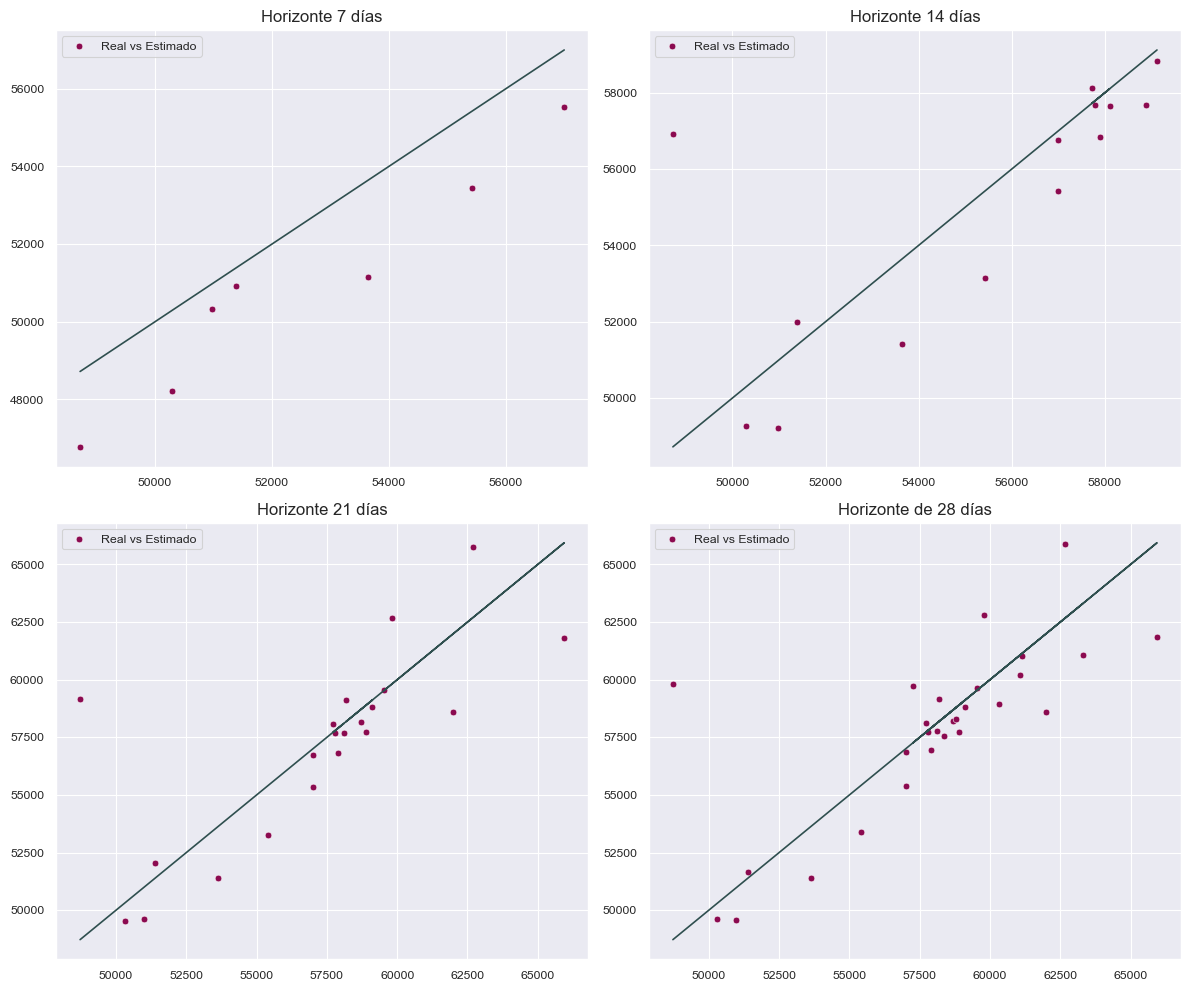

In [56]:
plt.rcParams.update({'figure.figsize' : (12 , 10)})
fig , axes = plt.subplots(nrows = 2 , ncols = 2)

# Horizonte de 7 días
sns.scatterplot(x = test7 , y = yhat7_aic , ax = axes[0 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 0].plot(test7 , test7 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 0].set_title('Horizonte 7 días' , fontsize = 12)

# Horizonte de 14 días
sns.scatterplot(x = test14 , y = yhat14_aic , ax = axes[0 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 1].plot(test14 , test14 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 1].set_title('Horizonte 14 días' , fontsize = 12)

# Horizonte de 21 días
sns.scatterplot(x = test21 , y = yhat21_aic , ax = axes[1 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 0].plot(test21 , test21 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 0].set_title('Horizonte 21 días' , fontsize = 12)

# Horizonte de 28 días
sns.scatterplot(x = test28 , y = yhat28_aic , ax = axes[1 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 1].plot(test28 , test28 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 1].set_title('Horizonte de 28 días' , fontsize = 12)

plt.tight_layout()
plt.show()



De lo anterior podemos observar que para los horizontes de 21 y 24 días los datos estimados se encuentran cerca de los reales, lo que indica que el modelo a largo plazo tiene una mejor prediccion que a corto plazo.

### **Conclusiones criterio AIC**

En resumen, aunque el modelo ARIMA se ajusta bien a los datos de entrenamiento según el criterio AIC, los diagnósticos revelan limitaciones. La prueba de Shapiro-Wilk indica que los residuos no son normales, y el estadístico de Durbin-Watson sugiere autocorrelación. A pesar de esto, los gráficos de predicción para diferentes horizontes muestran una tendencia adecuada, aunque con variabilidad en los errores. El modelo es útil, pero mejorar la independencia y distribución de los residuos podría requerir ajustar parámetros o probar otros modelos.

## **Criterio BIC**

### **Modelo ajustado**

Inicialmente, se ajustará el modelo teniendo en cuenta los mejores ordenes obtenidos anteriormente para el criterio de información **bayesiano**

In [57]:
best_order_bic = results['BIC']['best_order']
model_bic = ARIMA(train, order = best_order_bic)
model_fit_bic = model_bic.fit()

La siguiente gráfica representa la predicción realizada utilizando el modelo ARIMA ajustado al conjunto de datos de entrenamiento y al mejor orden obtenido para el criterio BIC

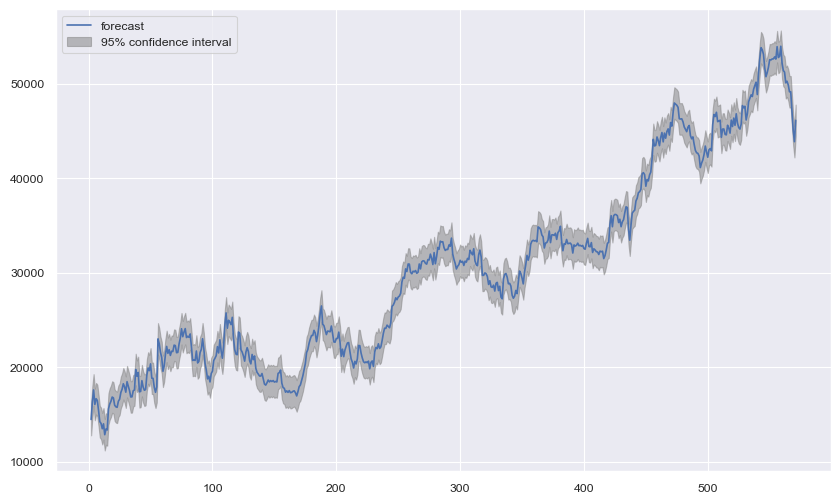

In [58]:
plt.rcParams.update({'figure.figsize': (10,6)})
plot_predict(model_fit_bic, 2);
# El valor 2 significa que la predicción comenzará desde la segunda observación.
plt.show();

Al ver la gráfica notamos que la cobertura que abarca el intervalo de confianza es algo ancha. Lo que podría indicar una precisión aceptable en predecir los pronósticos.

### **Modelo ARIMA con rolling forecast**

Ahora, apliquemos el modelo ARIMA con rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio BIC

In [59]:
print('ARIMA Rolling BIC- Horizonte de 7 días.')
yhat7_bic = arima_rolling(train_list, test7, best_order_bic)

print('\nARIMA Rolling BIC - Horizonte de 14 días.')
yhat14_bic = arima_rolling(train_list, test14, best_order_bic)

print('\nARIMA Rolling BIC - Horizonte de 21 días.')
yhat21_bic = arima_rolling(train_list, test21, best_order_bic)

print('\nARIMA Rolling BIC - Horizonte de 28 días.')
yhat28_bic = arima_rolling(train_list, test28, best_order_bic)

ARIMA Rolling BIC- Horizonte de 7 días.
predicho = 63205.500175, esperado = 48720.000000
predicho = 49854.098331, esperado = 50300.000000
predicho = 49755.713147, esperado = 50980.000000
predicho = 51042.573500, esperado = 51380.000000
predicho = 51327.938581, esperado = 53640.000000
predicho = 53479.356197, esperado = 55420.000000
predicho = 55332.084162, esperado = 57000.000000

ARIMA Rolling BIC - Horizonte de 14 días.
predicho = 56912.834112, esperado = 48720.000000
predicho = 49427.048330, esperado = 50300.000000
predicho = 50749.725255, esperado = 50980.000000
predicho = 51293.000550, esperado = 51380.000000
predicho = 51604.893359, esperado = 53640.000000
predicho = 53605.513308, esperado = 55420.000000
predicho = 55216.870134, esperado = 57000.000000
predicho = 56677.787409, esperado = 57000.000000
predicho = 56722.291431, esperado = 57900.000000
predicho = 57574.714026, esperado = 58100.000000
predicho = 57798.638024, esperado = 57720.000000
predicho = 57493.309042, esperado =

Veamos gráficamente lo anterior.

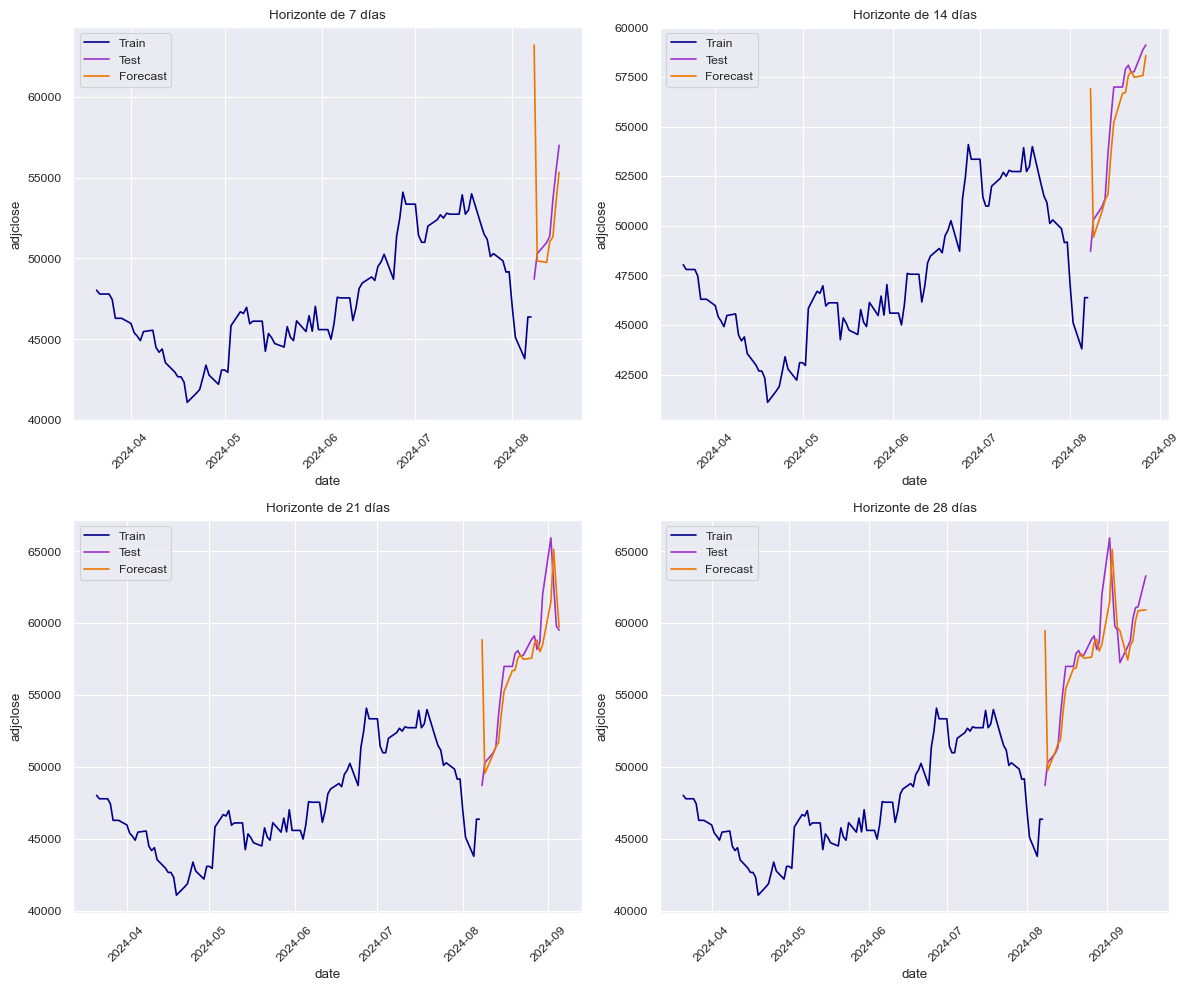

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# -100: seleccionar los últimos 100 elementos.

# Horizonte de 7 días
sns.lineplot(ax = axs[0, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = test7, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = yhat7_bic, label = 'Forecast', color = '#EE7600')
axs[0, 0].set_title('Horizonte de 7 días')
axs[0, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = test14, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = yhat14_bic, label = 'Forecast', color = '#EE7600')
axs[0, 1].set_title('Horizonte de 14 días')
axs[0, 1].tick_params(axis = 'x', rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = test21, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = yhat21_bic, label = 'Forecast', color = '#EE7600')
axs[1, 0].set_title('Horizonte de 21 días')
axs[1, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = test28, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = yhat28_bic, label = 'Forecast', color = '#EE7600')
axs[1, 1].set_title('Horizonte de 28 días')
axs[1, 1].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()


### **Modelo ARIMA sin rolling forecast**

Veamos ahora el modelo ARIMA sin rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio BIC


In [61]:
def arima_sin_rolling(test, modelo):
    # Calcular el número de pasos de predicción basados en el tamaño del conjunto de prueba
    forecast_steps = len(test)
    
    # Realizar las predicciones para el número de pasos determinado
    forecast_tipo = modelo.forecast(steps=forecast_steps)
    
    # Convertir a un array para acceder por índice numérico
    forecast_values = forecast_tipo.values
    
    # Imprimir los valores observados y predichos
    for i in range(len(test)):
        observado = test[i]  # Valores observados
        predicho = forecast_values[i]  # Acceder a los valores predichos por índice
        print(f'Predicho: {predicho}, Observado: {observado}')

    # Devolver las predicciones
    return forecast_values

In [62]:
print('ARIMA sin Rolling AIC - Horizonte de 7 días.')
yhat7_sin_bic = arima_sin_rolling(test7, model_fit_bic)

print('\nARIMA sin Rolling AIC - Horizonte de 14 días.')
yhat14_sin_bic = arima_sin_rolling(test14, model_fit_bic)

print('\nARIMA sin Rolling AIC - Horizonte de 21 días.')
yhat21_sin_bic = arima_sin_rolling(test21, model_fit_bic)

print('\nARIMA sin Rolling AIC - Horizonte de 28 días')
yhat28_sin_bic = arima_sin_rolling(test28, model_fit_bic)

ARIMA sin Rolling AIC - Horizonte de 7 días.
Predicho: 46578.33725610923, Observado: 48720.0
Predicho: 46398.25134313079, Observado: 50300.0
Predicho: 46561.76543367271, Observado: 50980.0
Predicho: 46413.298197321186, Observado: 51380.0
Predicho: 46548.103217468415, Observado: 53640.0
Predicho: 46425.70319236208, Observado: 55420.0
Predicho: 46536.83975188834, Observado: 57000.0

ARIMA sin Rolling AIC - Horizonte de 14 días.
Predicho: 46578.33725610923, Observado: 48720.0
Predicho: 46398.25134313079, Observado: 50300.0
Predicho: 46561.76543367271, Observado: 50980.0
Predicho: 46413.298197321186, Observado: 51380.0
Predicho: 46548.103217468415, Observado: 53640.0
Predicho: 46425.70319236208, Observado: 55420.0
Predicho: 46536.83975188834, Observado: 57000.0
Predicho: 46435.93017402997, Observado: 57000.0
Predicho: 46527.55387506013, Observado: 57900.0
Predicho: 46444.361548141016, Observado: 58100.0
Predicho: 46519.898370823386, Observado: 57720.0
Predicho: 46451.312579413854, Observad

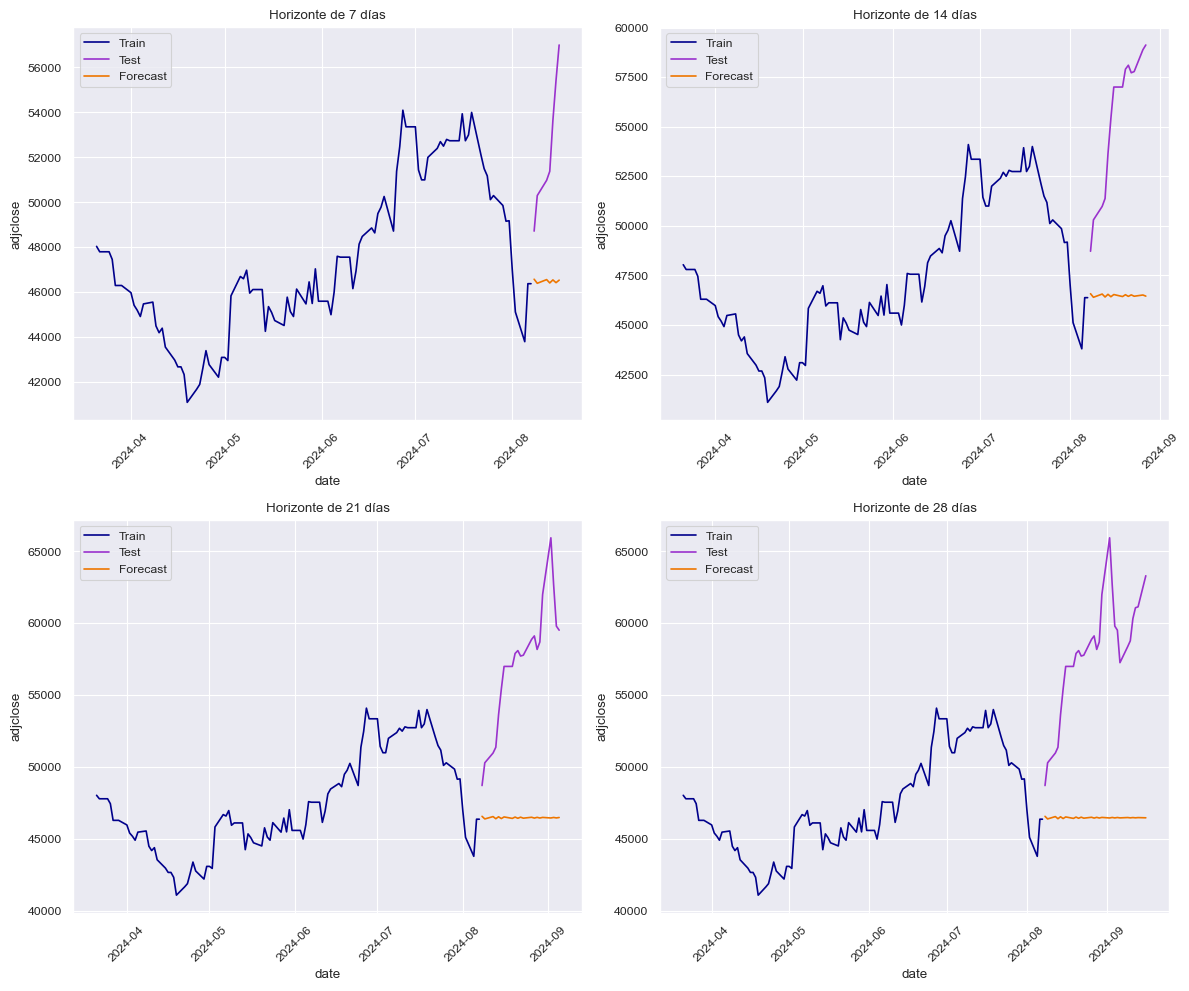

In [63]:
fig , axs = plt.subplots(2 , 2 , figsize = (12 , 10))

# Horizonte de 7 días
sns.lineplot(ax = axs[0 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = test7 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = yhat7_sin_bic , label = "Forecast" , color = '#EE7600')
axs[0 , 0].set_title("Horizonte de 7 días")
axs[0 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = test14 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = yhat14_sin_bic , label = "Forecast" , color = '#EE7600')
axs[0 , 1].set_title("Horizonte de 14 días")
axs[0 , 1].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = test21 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = yhat21_sin_bic , label = "Forecast" , color = '#EE7600')
axs[1 , 0].set_title("Horizonte de 21 días")
axs[1 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = test28 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = yhat28_sin_bic , label = "Forecast" , color = '#EE7600')
axs[1 , 1].set_title("Horizonte de 28 días")
axs[1 , 1].tick_params(axis = 'x' , rotation = 45)

plt.tight_layout()
plt.show()


### **Análisis de residuos modelo ARIMA basado en el criterio BIC**

#### **Normalidad de los residuos**

Ahora, veamos la normalidad del conjunto de datos residuales por medio de la prueba de `Shapiro-Wilk` y luego veamos gráficamente la distribución.

- **Hipótesis Nula (H₀):** La muestra parece provenir de una distribución normal.
- **Hipótesis Alternativa (H₁):** La muestra NO parece provenir de una distribución normal.

Statistic = 0.757
P-Value = 3.433794743056932e-28
Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.


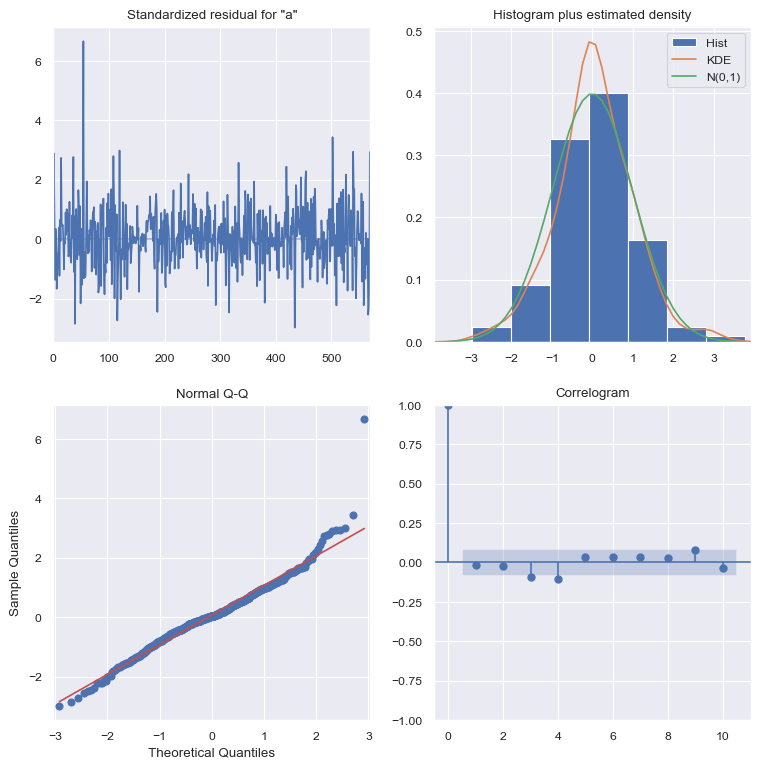

In [64]:
qq2 = model_fit_bic.plot_diagnostics(figsize=(9,9))

stat2, pvalue2 = shapiro(model_fit_bic.resid)
print(f'Statistic = {stat2:.3f}')
print(f'P-Value = {pvalue2}')
if(pvalue2 < 0.05):
    print('Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.')
else:
    print('No se rechaza la hipótesis nula, por lo tanto los residuales siguen una distribución normal.')

#### **Independencia de los residuos**

Uno de los principales supuestos de los modelos es que NO existe autocorrelación entre los residuos. Se usará la prueba de `Durbin-Watson`, teniendo en cuenta las siguientes hipótesis.


- **Hipótesis Nula (H₀):** No existe correlación entre los residuos
- **Hipótesis Alternativa (H₁):** Los residuos están correlacionados

Usaremos el estadístico de prueba para determinar si hay o no autocorrelación entre los residuos, dado que la prueba en sí no da un p-valor en su cálculo

Si:
- d = 2, NO hay autocorrelación
- d < 2, correlación positiva
- d > 2, correlación negativa.

In [65]:
dw2 = durbin_watson(model_fit_bic.resid)

print(f'Statistic d = {dw2:.3f}')
if(dw2 < 1.5 or dw2 > 2.5):
    print('Se rechaza la hipótesis nula, los residuales están correlacionados.')
else:
    print('No se rechaza la hipótesis nula, no existe correlación entre los residuales.')

Statistic d = 1.677
No se rechaza la hipótesis nula, no existe correlación entre los residuales.


### **Comparación de modelos - Criterio BIC**




#### **Tablas de error**

Veamos las tablas de error tanto para el modelo ARIMA con y sin rolling forecast teniendo en cuenta el criterio BIC

In [66]:
accuracy7_bic =  forecast_accuracy(np.array(test7), np.array(yhat7_bic), "7 días")
accuracy14_bic = forecast_accuracy(np.array(test14), np.array(yhat14_bic), "14 días")
accuracy21_bic = forecast_accuracy(np.array(test21), np.array(yhat21_bic), "21 días")
accuracy28_bic = forecast_accuracy(np.array(test28), np.array(yhat28_bic), "28 días")

accuracy_rolling2 = pd.concat([accuracy7_bic, accuracy14_bic, accuracy21_bic, accuracy28_bic])

In [67]:
accuracy7_not_bic = forecast_accuracy(np.array(test7), np.array(yhat7_sin_bic), "7 días")
accuracy14_not_bic = forecast_accuracy(np.array(test14), np.array(yhat14_sin_bic), "14 días")
accuracy21_not_bic = forecast_accuracy(np.array(test21), np.array(yhat21_sin_bic), "21 días")
accuracy28_not_bic = forecast_accuracy(np.array(test28), np.array(yhat28_sin_bic), "28 días")

accuracy_not_rolling2 = pd.concat([ accuracy7_not_bic, accuracy14_not_bic, accuracy21_not_bic, accuracy28_not_bic])

In [68]:
accuracy_rolling2

,MAE,MSE,MAPE,RMSE,R2
7 días,3201.962322,3.193356e+07,0.054403,5650.979033,-3.236129
14 días,1373.824959,5.884836e+06,0.024780,2425.868180,0.500335
21 días,1666.137097,7.699694e+06,0.028530,2774.832252,0.552369
28 días,1537.212416,6.660070e+06,0.026083,2580.711221,0.565488


In [69]:
accuracy_not_rolling2

,MAE,MSE,MAPE,RMSE,R2
7 días,5996.814515,4.352420e+07,0.128986,6597.287135,-4.773678
14 días,8794.858207,8.917968e+07,0.189205,9443.499178,-6.571993
21 días,10692.430184,1.315697e+08,0.230021,11470.385163,-6.648972
28 días,11407.971533,1.455038e+08,0.245417,12062.496707,-8.492876


#### **Gráficos de correlación**

En esta parte, se puede observar los gráficos de correlación entre la observación real y su predicción en el test para cada uno de los horizontes, teniendo en cuenta el criterio BIC y el uso de rolling forecasting.


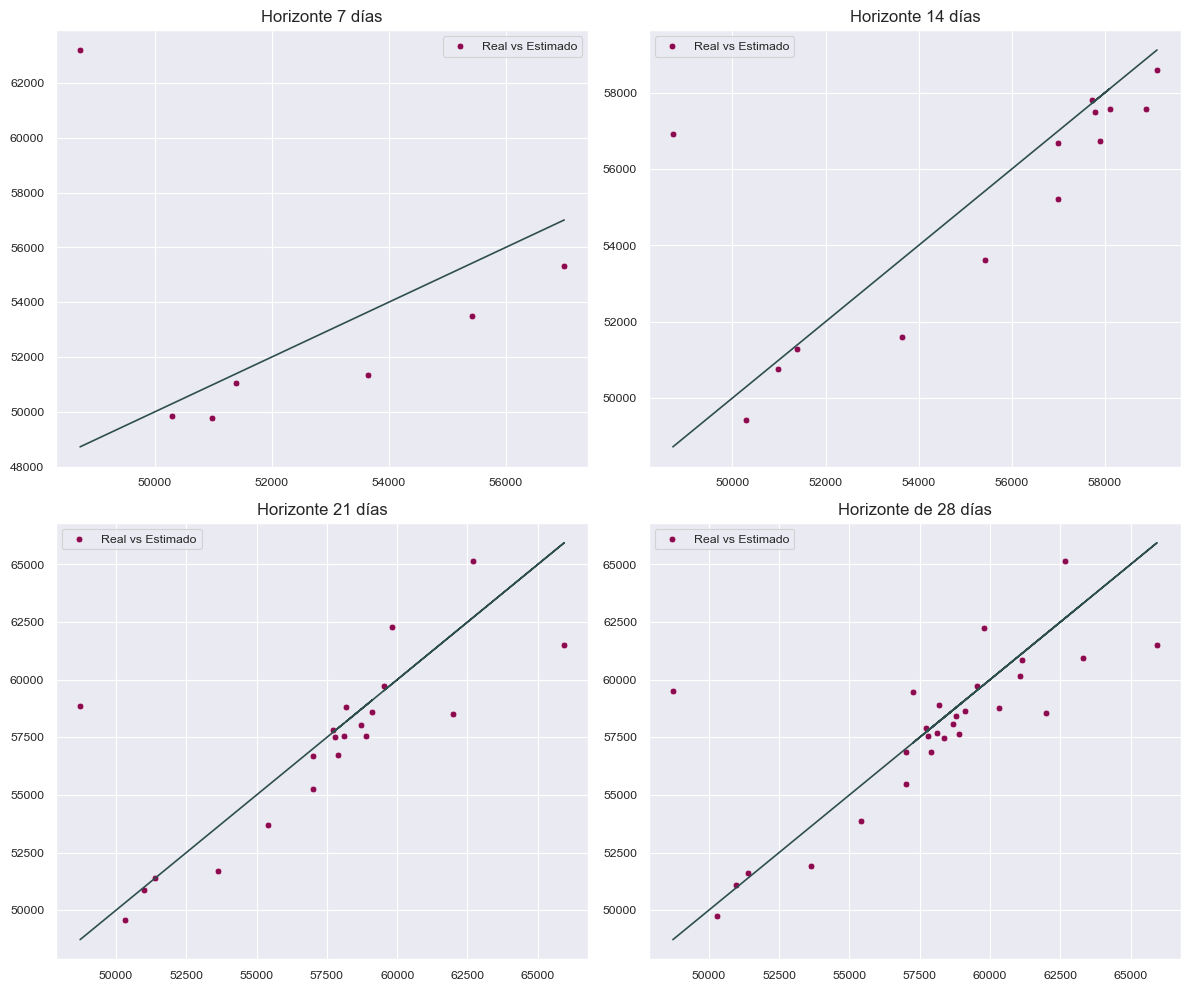

In [70]:
plt.rcParams.update({'figure.figsize' : (12 , 10)})
fig , axes = plt.subplots(nrows = 2 , ncols = 2)

# Horizonte de 7 días
sns.scatterplot(x = test7 , y = yhat7_bic , ax = axes[0 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 0].plot(test7 , test7 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 0].set_title('Horizonte 7 días' , fontsize = 12)

# Horizonte de 14 días
sns.scatterplot(x = test14 , y = yhat14_bic , ax = axes[0 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 1].plot(test14 , test14 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 1].set_title('Horizonte 14 días' , fontsize = 12)

# Horizonte de 21 días
sns.scatterplot(x = test21 , y = yhat21_bic , ax = axes[1 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 0].plot(test21 , test21 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 0].set_title('Horizonte 21 días' , fontsize = 12)

# Horizonte de 28 días
sns.scatterplot(x = test28 , y = yhat28_bic , ax = axes[1 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 1].plot(test28 , test28 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 1].set_title('Horizonte de 28 días' , fontsize = 12)

plt.tight_layout()
plt.show()



### **Conclusiones criterio BIC**

## **Criterio HQIC**

### **Modelo ajustado**

Inicialmente, se ajustará el modelo teniendo en cuenta los mejores ordenes obtenidos anteriormente para el criterio de información de **Hannan- Quinn**

In [71]:
best_order_hqic = results['HQIC']['best_order']
model_hqic = ARIMA(train, order = best_order_hqic)
model_fit_hqic = model_hqic.fit()

La siguiente gráfica representa la predicción realizada utilizando el modelo ARIMA ajustado al conjunto de datos de entrenamiento y al mejor orden obtenido para el criterio HQIC

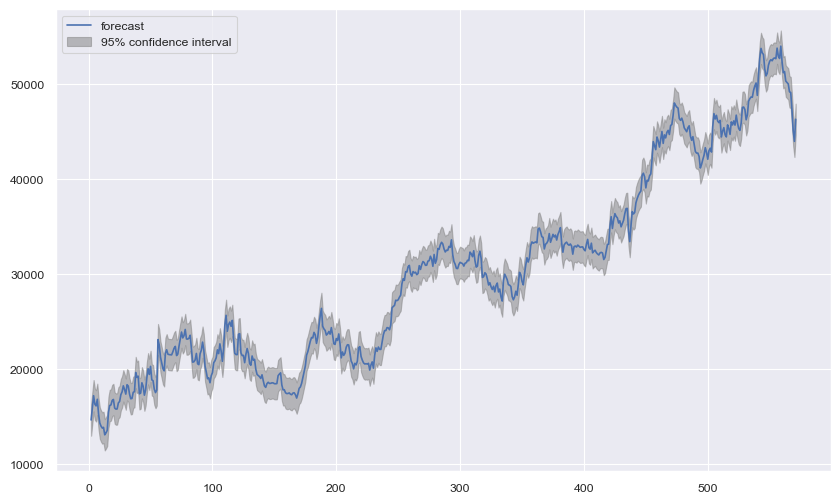

In [72]:
plt.rcParams.update({'figure.figsize': (10,6)})
plot_predict(model_fit_hqic, 2);
# El valor 2 significa que la predicción comenzará desde la segunda observación.
plt.show();

Al ver la gráfica notamos que la cobertura que abarca el intervalo de confianza es algo ancha. Lo que podría indicar una adecuada precisión en predecir los pronósticos.

### **Modelo ARIMA con rolling forecast**

Ahora, apliquemos el modelo ARIMA con rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio HQIC

In [73]:
print('ARIMA Rolling HQIC- Horizonte de 7 días.')
yhat7_hqic = arima_rolling(train_list, test7, best_order_hqic)

print('\nARIMA Rolling HQIC - Horizonte de 14 días.')
yhat14_hqic = arima_rolling(train_list, test14, best_order_hqic)

print('\nARIMA Rolling HQIC - Horizonte de 21 días.')
yhat21_hqic = arima_rolling(train_list, test21, best_order_hqic)

print('\nARIMA Rolling HQIC - Horizonte de 28 días.')
yhat28_hqic = arima_rolling(train_list, test28, best_order_hqic)

ARIMA Rolling HQIC- Horizonte de 7 días.
predicho = 63025.165028, esperado = 48720.000000
predicho = 50219.160043, esperado = 50300.000000
predicho = 50531.297289, esperado = 50980.000000
predicho = 52402.961548, esperado = 51380.000000
predicho = 51453.473058, esperado = 53640.000000
predicho = 53385.099326, esperado = 55420.000000
predicho = 55194.570459, esperado = 57000.000000

ARIMA Rolling HQIC - Horizonte de 14 días.
predicho = 56509.494404, esperado = 48720.000000
predicho = 49344.382882, esperado = 50300.000000
predicho = 50375.673791, esperado = 50980.000000
predicho = 51719.449476, esperado = 51380.000000
predicho = 51286.805902, esperado = 53640.000000
predicho = 53294.245843, esperado = 55420.000000
predicho = 55063.184317, esperado = 57000.000000
predicho = 56399.751376, esperado = 57000.000000
predicho = 56604.232304, esperado = 57900.000000
predicho = 57519.066042, esperado = 58100.000000
predicho = 57912.677966, esperado = 57720.000000
predicho = 57582.414700, esperado

Veamos gráficamente lo anterior.

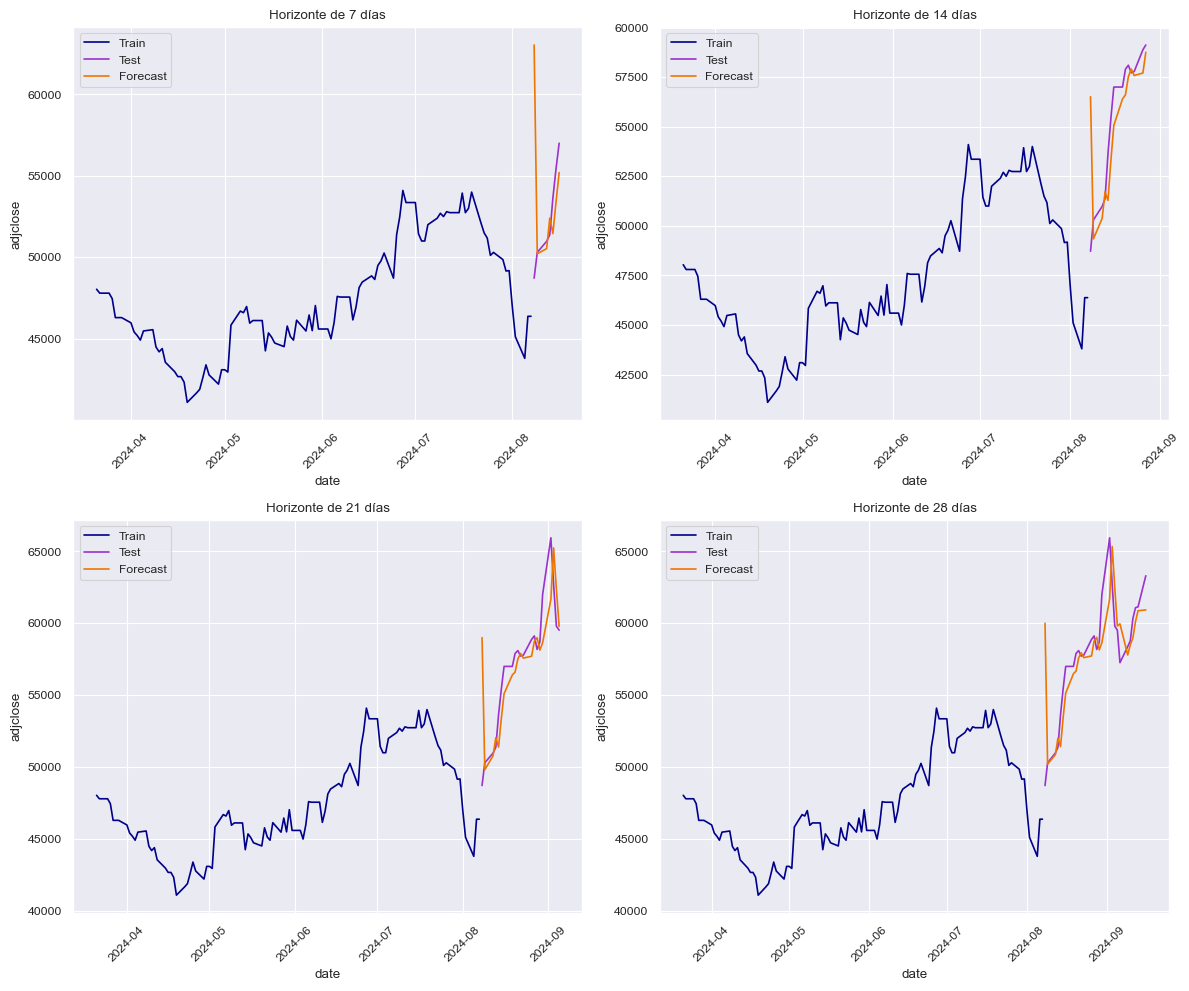

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# -100: seleccionar los últimos 100 elementos.

# Horizonte de 7 días
sns.lineplot(ax = axs[0, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = test7, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = yhat7_hqic, label = 'Forecast', color = '#EE7600')
axs[0, 0].set_title('Horizonte de 7 días')
axs[0, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = test14, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = yhat14_hqic, label = 'Forecast', color = '#EE7600')
axs[0, 1].set_title('Horizonte de 14 días')
axs[0, 1].tick_params(axis = 'x', rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = test21, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = yhat21_hqic, label = 'Forecast', color = '#EE7600')
axs[1, 0].set_title('Horizonte de 21 días')
axs[1, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = test28, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = yhat28_hqic, label = 'Forecast', color = '#EE7600')
axs[1, 1].set_title('Horizonte de 28 días')
axs[1, 1].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()


### **Modelo ARIMA sin rolling forecast**

Veamos ahora el modelo ARIMA sin rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio HQIC


In [75]:
print('ARIMA sin Rolling AIC - Horizonte de 7 días.')
yhat7_sin_hqic = arima_sin_rolling(test7, model_fit_hqic)

print('\nARIMA sin Rolling AIC - Horizonte de 14 días.')
yhat14_sin_hqic = arima_sin_rolling(test14, model_fit_hqic)

print('\nARIMA sin Rolling AIC - Horizonte de 21 días.')
yhat21_sin_hqic = arima_sin_rolling(test21, model_fit_hqic)

print('\nARIMA sin Rolling AIC - Horizonte de 28 días')
yhat28_sin_hqic = arima_sin_rolling(test28, model_fit_hqic)

ARIMA sin Rolling AIC - Horizonte de 7 días.
Predicho: 46779.309377534344, Observado: 48720.0
Predicho: 46470.4733200552, Observado: 50300.0
Predicho: 46462.53623532002, Observado: 50980.0
Predicho: 46462.53623532002, Observado: 51380.0
Predicho: 46462.53623532002, Observado: 53640.0
Predicho: 46462.53623532002, Observado: 55420.0
Predicho: 46462.53623532002, Observado: 57000.0

ARIMA sin Rolling AIC - Horizonte de 14 días.
Predicho: 46779.309377534344, Observado: 48720.0
Predicho: 46470.4733200552, Observado: 50300.0
Predicho: 46462.53623532002, Observado: 50980.0
Predicho: 46462.53623532002, Observado: 51380.0
Predicho: 46462.53623532002, Observado: 53640.0
Predicho: 46462.53623532002, Observado: 55420.0
Predicho: 46462.53623532002, Observado: 57000.0
Predicho: 46462.53623532002, Observado: 57000.0
Predicho: 46462.53623532002, Observado: 57900.0
Predicho: 46462.53623532002, Observado: 58100.0
Predicho: 46462.53623532002, Observado: 57720.0
Predicho: 46462.53623532002, Observado: 5778

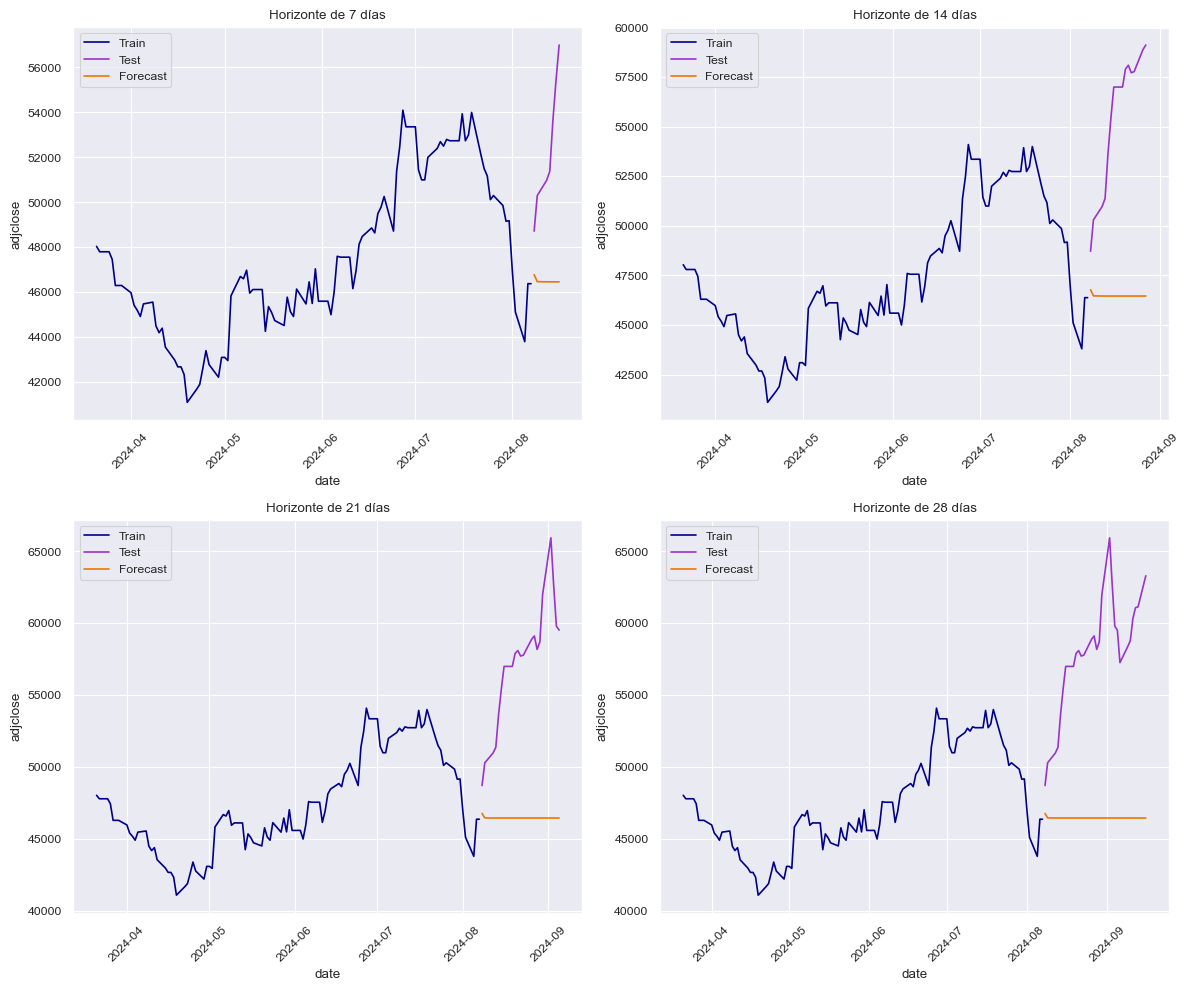

In [76]:
fig , axs = plt.subplots(2 , 2 , figsize = (12 , 10))

# Horizonte de 7 días
sns.lineplot(ax = axs[0 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = test7 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = yhat7_sin_hqic , label = "Forecast" , color = '#EE7600')
axs[0 , 0].set_title("Horizonte de 7 días")
axs[0 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = test14 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = yhat14_sin_hqic , label = "Forecast" , color = '#EE7600')
axs[0 , 1].set_title("Horizonte de 14 días")
axs[0 , 1].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = test21 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = yhat21_sin_hqic , label = "Forecast" , color = '#EE7600')
axs[1 , 0].set_title("Horizonte de 21 días")
axs[1 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = test28 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = yhat28_sin_hqic , label = "Forecast" , color = '#EE7600')
axs[1 , 1].set_title("Horizonte de 28 días")
axs[1 , 1].tick_params(axis = 'x' , rotation = 45)

plt.tight_layout()
plt.show()


### **Análisis de residuos modelo ARIMA basado en el criterio HQIC**

#### **Normalidad de los residuos**

Ahora, veamos la normalidad del conjunto de datos residuales por medio de la prueba de `Shapiro-Wilk` y luego veamos gráficamente la distribución.

- **Hipótesis Nula (H₀):** La muestra parece provenir de una distribución normal.
- **Hipótesis Alternativa (H₁):** La muestra NO parece provenir de una distribución normal.

Statistic = 0.753
P-Value = 2.2116616134743827e-28
Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.


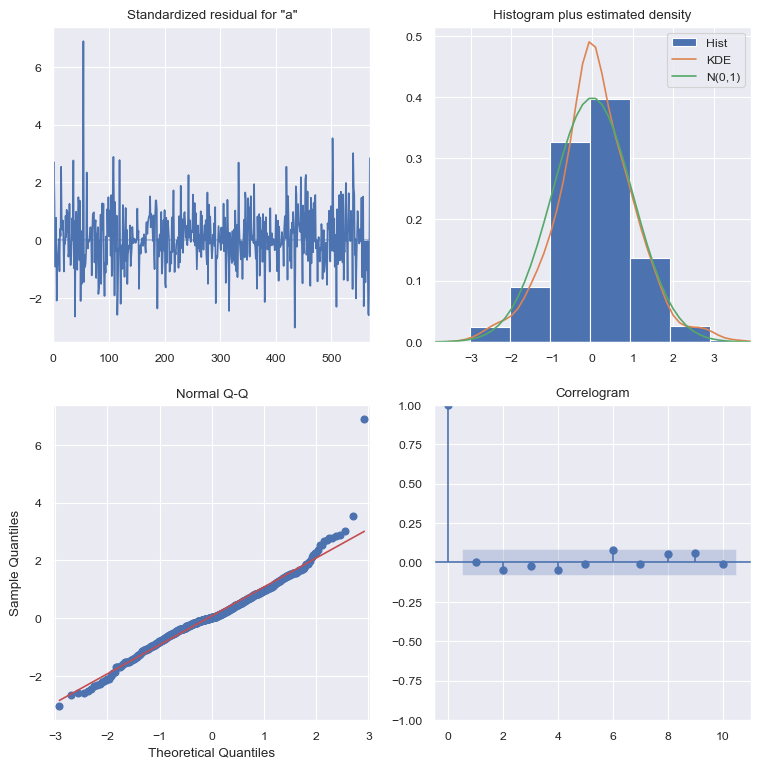

In [77]:
qq3 = model_fit_hqic.plot_diagnostics(figsize=(9,9))

stat3, pvalue3 = shapiro(model_fit_hqic.resid)
print(f'Statistic = {stat3:.3f}')
print(f'P-Value = {pvalue3}')
if(pvalue3 < 0.05):
    print('Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.')
else:
    print('No se rechaza la hipótesis nula, por lo tanto los residuales siguen una distribución normal.')

#### **Independencia de los residuos**

Uno de los principales supuestos de los modelos es que NO existe autocorrelación entre los residuos. Se usará la prueba de `Durbin-Watson`, teniendo en cuenta las siguientes hipótesis.


- **Hipótesis Nula (H₀):** No existe correlación entre los residuos
- **Hipótesis Alternativa (H₁):** Los residuos están correlacionados

Usaremos el estadístico de prueba para determinar si hay o no autocorrelación entre los residuos, dado que la prueba en sí no da un p-valor en su cálculo

Si:
- d = 2, NO hay autocorrelación
- d < 2, correlación positiva
- d > 2, correlación negativa.

In [78]:
dw3 = durbin_watson(model_fit_hqic.resid)

print(f'Statistic d = {dw3:.3f}')
if(dw3 < 1.5 or dw3 > 2.5):
    print('Se rechaza la hipótesis nula, los residuales están correlacionados.')
else:
    print('No se rechaza la hipótesis nula, no existe correlación entre los residuales.')

Statistic d = 1.639
No se rechaza la hipótesis nula, no existe correlación entre los residuales.


### **Comparación de modelos - Criterio HQIC**




#### **Tablas de error**

Veamos las tablas de error tanto para el modelo ARIMA con y sin rolling forecast teniendo en cuenta el criterio HQIC

In [79]:
accuracy7_hqic =  forecast_accuracy(np.array(test7), np.array(yhat7_hqic), "7 días")
accuracy14_hqic = forecast_accuracy(np.array(test14), np.array(yhat14_hqic), "14 días")
accuracy21_hqic = forecast_accuracy(np.array(test21), np.array(yhat21_hqic), "21 días")
accuracy28_hqic = forecast_accuracy(np.array(test28), np.array(yhat28_hqic), "28 días")

accuracy_rolling3 = pd.concat([accuracy7_hqic, accuracy14_hqic, accuracy21_hqic, accuracy28_hqic])

In [80]:
accuracy7_not_hqic = forecast_accuracy(np.array(test7), np.array(yhat7_sin_hqic), "7 días")
accuracy14_not_hqic = forecast_accuracy(np.array(test14), np.array(yhat14_sin_hqic), "14 días")
accuracy21_not_hqic = forecast_accuracy(np.array(test21), np.array(yhat21_sin_hqic), "21 días")
accuracy28_not_hqic = forecast_accuracy(np.array(test28), np.array(yhat28_sin_hqic), "28 días")

accuracy_not_rolling3 = pd.concat([ accuracy7_not_hqic, accuracy14_not_hqic, accuracy21_not_hqic, accuracy28_not_hqic])

In [81]:
accuracy_rolling3

,MAE,MSE,MAPE,RMSE,R2
7 días,3126.360914,3.115334e+07,0.052901,5581.517493,-3.132628
14 días,1465.233580,5.703128e+06,0.026693,2388.122313,0.515764
21 días,1743.559482,7.951474e+06,0.029941,2819.835750,0.537731
28 días,1621.957831,7.283346e+06,0.027508,2698.767540,0.524824


In [82]:
accuracy_not_rolling3

,MAE,MSE,MAPE,RMSE,R2
7 días,5982.505161,4.368725e+07,0.128717,6609.633329,-4.795308
14 días,8795.698748,8.945109e+07,0.189286,9457.858878,-6.595039
21 días,10701.048992,1.319784e+08,0.230302,11488.183589,-6.672728
28 días,11419.438399,1.459466e+08,0.245767,12080.835418,-8.521762


#### **Gráficos de correlación**

En esta parte, se puede observar los gráficos de correlación entre la observación real y su predicción en el test para cada uno de los horizontes, teniendo en cuenta el criterio HQIC y el uso de rolling forecasting.


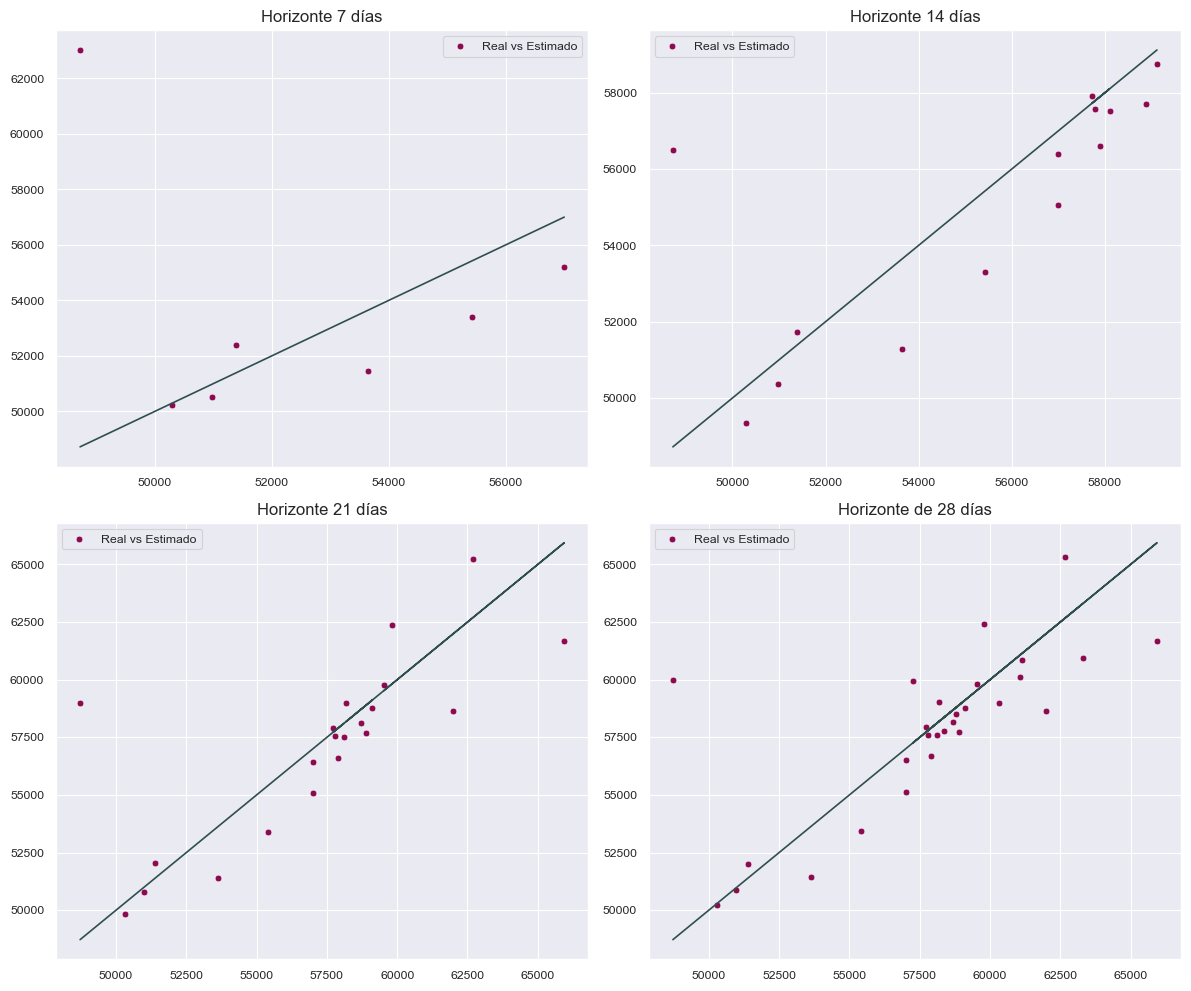

In [83]:
plt.rcParams.update({'figure.figsize' : (12 , 10)})
fig , axes = plt.subplots(nrows = 2 , ncols = 2)

# Horizonte de 7 días
sns.scatterplot(x = test7 , y = yhat7_hqic , ax = axes[0 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 0].plot(test7 , test7 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 0].set_title('Horizonte 7 días' , fontsize = 12)

# Horizonte de 14 días
sns.scatterplot(x = test14 , y = yhat14_hqic , ax = axes[0 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 1].plot(test14 , test14 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 1].set_title('Horizonte 14 días' , fontsize = 12)

# Horizonte de 21 días
sns.scatterplot(x = test21 , y = yhat21_hqic , ax = axes[1 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 0].plot(test21 , test21 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 0].set_title('Horizonte 21 días' , fontsize = 12)

# Horizonte de 28 días
sns.scatterplot(x = test28 , y = yhat28_hqic , ax = axes[1 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 1].plot(test28 , test28 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 1].set_title('Horizonte de 28 días' , fontsize = 12)

plt.tight_layout()
plt.show()



### **Conclusiones criterio HQIC**

Podemos concluir que las predicciones de los horizontes 14, 21 y 28 se ajustan de mejor manera a los valores reales, que para el horizonte de 7 días. Lo que quiere decir que el modelo mejora a largo plazo.